In [1]:
# modified from the original routine of model_uvlf.ipynb 
# Xuejian Shen, 2024

#import hmf
#from hmf import mass_function
from astropy.cosmology import FlatLambdaCDM

import numpy as np
import astropy.constants as con
import matplotlib.pyplot as plt
import matplotlib
import scipy
# define matplotlib style
matplotlib.style.use('classic')
matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22)
matplotlib.rc('xtick.major', size=14 , width=2)
matplotlib.rc('xtick.minor', size=7, width=2, visible=True)
matplotlib.rc('ytick.major', size=14 , width=2)
matplotlib.rc('ytick.minor', size=7, width=2, visible=True)
matplotlib.rc('lines',linewidth=2, markersize=20)
matplotlib.rc('axes', linewidth=2, labelsize=28, labelpad=2.5)
matplotlib.rc('legend', fontsize=23, loc='best', frameon=False, numpoints=1)
matplotlib.rc('font', family='STIXGeneral')
matplotlib.rc('mathtext', fontset='stix')

In [2]:
from utilities import hmf_cosmo
from utilities import star_formation as sf
from utilities import lf_mapping
from utilities import observation_data as obs
from utilities import variability as vab
from utilities import lf_processing

### cosmological parameters and HMF

In [3]:
# define cosmology; Planck collaboration 2020
parameters_std = {
    'hubble': 0.6781,
    'Om0'   : 0.309,
    'Omcdm': 0.1191,
    'Omb'  : 2.249/100.,
    'As'   : 2.092e-9,
    'ns': 0.9747,
    'S8': 0.821,
    'tau': 0.051
}
parameters_std['fbaryon'] = parameters_std['Omb']/(parameters_std['Omb'] + parameters_std['Omcdm'])
parameters_std['sigma8'] = parameters_std['S8']/(parameters_std['Om0']/0.3)**0.5

Tcmb = 2.7255 # Fixsen 2009
mnu = [0.0, 0.0, 0.06]
Neff = 3.046

cosmo_std = FlatLambdaCDM(
            H0=100*parameters_std['hubble'], 
            Om0 = parameters_std['Om0'], 
            Ob0 = parameters_std['Omb'] / parameters_std['hubble']**2, 
            Tcmb0=Tcmb, 
            Neff=Neff, 
            m_nu=mnu
)

# Early dark energy model
parameters_ede = {
    'hubble': 0.7483,
    'Om0'   : 0.287,
    'Omcdm': 0.1372,
    'Omb'  : 2.278/100.,
    'As'   : 2.146e-9,
    'ns': 1.003,
    'S8': 0.829,
    'tau': 0.052,
    # ede parameters
    'fzc': 0.179,
    'zc' : 10**(3.528),
    'thetai': 2.806,
    'maxion': 4.38e-28,
    'fa'    : 0.213,
    'n'     : 3
}
parameters_ede['fbaryon'] = parameters_ede['Omb']/(parameters_ede['Omb'] + parameters_ede['Omcdm'])
parameters_ede['sigma8'] = parameters_ede['S8']/(parameters_ede['Om0']/0.3)**0.5

cosmo_ede = FlatLambdaCDM(
            H0=100*parameters_ede['hubble'], 
            Om0 = parameters_ede['Om0'], 
            Ob0 = parameters_ede['Omb'] / parameters_ede['hubble']**2, 
            Tcmb0=Tcmb, 
            Neff=Neff, 
            m_nu=mnu
)

In [4]:
cosmo_std.age(6) - cosmo_std.age(100), cosmo_ede.age(6) - cosmo_ede.age(100)

(<Quantity 0.91178333 Gyr>, <Quantity 0.85765073 Gyr>)

### accretion rates and SFE

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_74012/3279140029.py:17: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  f = np.genfromtxt('./theory_data/GUREFT_Mdot.dat', names=True, dtype=None)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_74012/3279140029.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(f['Mhalo'][sel], 10**f['Mdot'][sel], '.', marker='o', mec=color, mfc='white', ms=10, mew=2)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_74012/3279140029.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(f['Mhalo'][sel], 10**f['Mdot'][sel], '.', marker='s', mec=color, mfc='white', ms=8, 

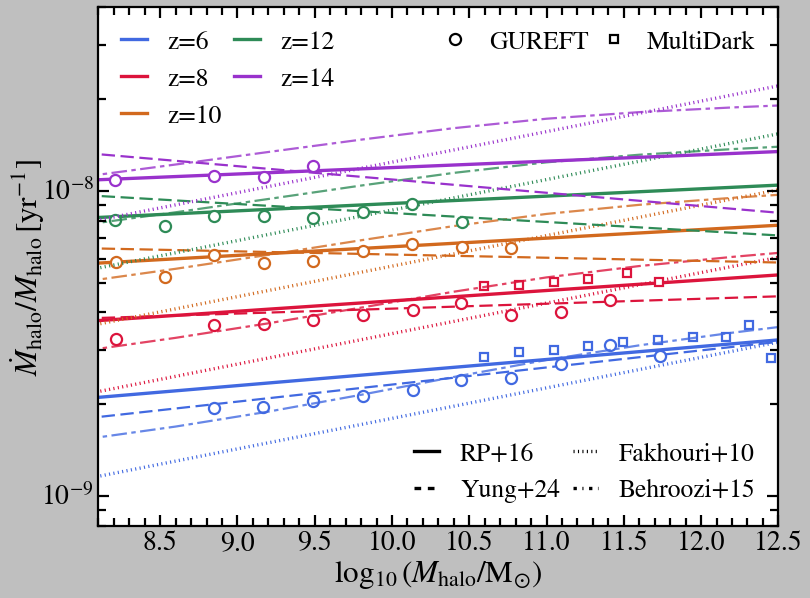

In [8]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

logmhalo_arr = np.linspace(8, 14, 101)
logmhalo_arr2 = np.linspace(8, 14, 11)

for redshift,color in zip([6, 8, 10, 12, 14],['royalblue','crimson','chocolate','seagreen','darkorchid']):
    mdot = sf.halo_accretion_rate_F10(10**logmhalo_arr, redshift, cosmo_std)
    plt.plot(logmhalo_arr, mdot/10**logmhalo_arr, c=color, lw=3, linestyle=':')

    mdot = sf.halo_accretion_rate_Y23(10**logmhalo_arr, redshift, cosmo_std)
    plt.plot(logmhalo_arr, mdot/10**logmhalo_arr, c=color, lw=2, linestyle='--', dashes=(12,5))

    mdot = sf.halo_accretion_rate_RP16(10**logmhalo_arr, redshift, cosmo_std)
    plt.plot(logmhalo_arr, mdot/10**logmhalo_arr, c=color, lw=3, linestyle='-', label='z='+str(redshift))

    f = np.genfromtxt('./theory_data/GUREFT_Mdot.dat', names=True, dtype=None)
    tag = f['tag'].astype(str)
    sel = (f['z']==redshift) & (tag=='Y24')
    plt.plot(f['Mhalo'][sel], 10**f['Mdot'][sel], '.', marker='o', mec=color, mfc='white', ms=10, mew=2)
    sel = (f['z']==redshift) & (tag=='MultiD')
    plt.plot(f['Mhalo'][sel], 10**f['Mdot'][sel], '.', marker='s', mec=color, mfc='white', ms=8, mew=2)

    mdot = sf.halo_accretion_rate_B15(10**logmhalo_arr2, redshift, cosmo_std) /  np.exp((np.log(10)*0.3)**2/2)
    plt.plot(logmhalo_arr2, mdot/10**logmhalo_arr2, c=color, lw=2, alpha=0.8, linestyle='-.', dashes=(14,4,4,4))

    #mdot = mdot_F23(10**logmhalo_arr, redshift, cosmo_std)
    #plt.plot(logmhalo_arr, mdot/10**logmhalo_arr, c=color, lw=2, alpha=0.8, linestyle='-')

l1, = plt.plot([],[],'k-', lw=3)
l2, = plt.plot([],[],'k--', lw=3)
l3, = plt.plot([],[],'k:', lw=3)
l4, = plt.plot([],[],'k-.', lw=3)
l5, = plt.plot([],[], '.', marker='o', mec='k', mfc='white', ms=10, mew=2)
l6, = plt.plot([],[], '.', marker='s', mec='k', mfc='white', ms=8, mew=2)
labels = ['RP+16', 'Yung+24', 'Fakhouri+10', 'Behroozi+15']
legend1 = plt.legend([l1,l2,l3,l4], labels, ncol =2, loc=4, fontsize=23, columnspacing=0.5, handlelength=1)
legend2 = plt.legend([l5,l6], ['GUREFT','MultiDark'], loc=1, ncol=2, fontsize=23, columnspacing=0.5, handlelength=1)

#f = np.genfromtxt('HaloAcc_Y23.dat')
#plt.plot(f[:,0], 10**f[:,1], 'r.', lw=2)
plt.legend(loc=2, fontsize=23, ncol=2, columnspacing=0.5, handlelength=1)
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlabel(r'$\log_{10}{(M_{\rm halo}/{\rm M}_{\odot})}$', fontsize=28)
plt.ylabel(r"$\dot{M}_{\rm halo}/M_{\rm halo}\,[{\rm yr}^{-1}]$", fontsize=28, labelpad=-5)

plt.xlim(8.1, 12.5); plt.ylim(8e-10, 4e-8); 
plt.yscale('log')
#plt.yticks([0.01, 0.1, 0.5], [r'$1\%$', r'$10\%$', r'$50\%$'])
plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/halo_accretion_rate.pdf")
#plt.show()

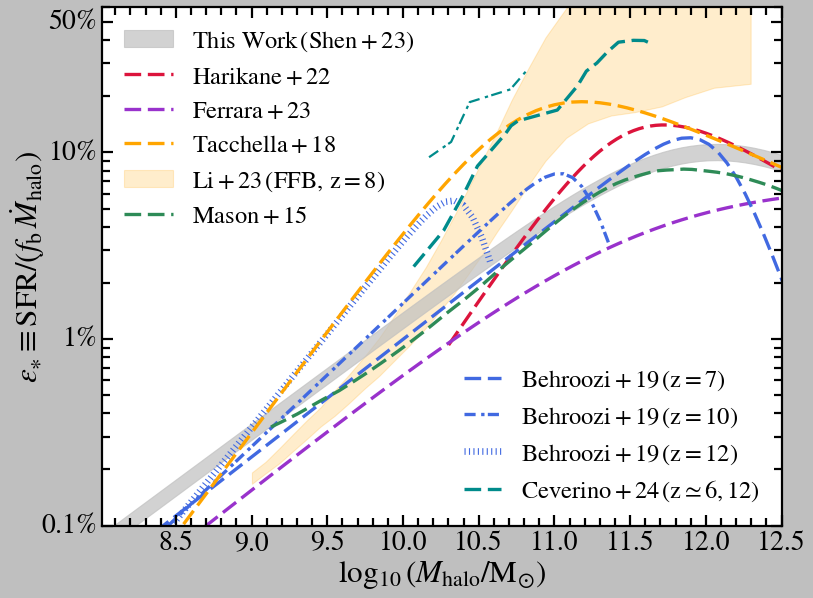

In [10]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.115, 0.12, 0.85, 0.81])

logmhalo_arr = np.linspace(8, 14, 101)
ylo = sf.star_formation_efficiency_fiducial(10**logmhalo_arr, fsfe=0.9)
yup = sf.star_formation_efficiency_fiducial(10**logmhalo_arr, fsfe=1.1)
#plt.plot(logmhalo_arr, star_formation_efficiency_fiducial(10**logmhalo_arr, parameters_std, fsfe=1),  
#         c='silver', lw=10, alpha=0.8, label=r"$\rm This\,\,Work$", zorder=-10)
#plt.plot(logmhalo_arr, star_formation_efficiency_fiducial(10**logmhalo_arr, parameters_std, fsfe=1.5),  
#         c='silver', lw=10, alpha=0.8, zorder=-10)
plt.fill_between(logmhalo_arr, ylo, yup, color='silver', alpha=0.7, #label=r"$\rm Shen+23$", zorder=1)
                 label=r"$\rm This\,\,Work\,(Shen+23)$", zorder=1)

logmhalo_arr = np.linspace(np.log10(2e10), 14, 101)
plt.plot(logmhalo_arr, sf.star_formation_efficiency_H22_zdep(10**logmhalo_arr) * 0.63,  
         c='crimson', dashes=(15,6), linestyle='--', lw=3, label=r"$\rm Harikane+22$")

logmhalo_arr = np.linspace(8, 14, 101)
redshift = 12
sfr  = sf.star_formation_rate_F23(10**logmhalo_arr, redshift=redshift, cosmo=cosmo_std, parameters=parameters_std)
mdot = sf.halo_accretion_rate_RP16(10**logmhalo_arr, redshift=redshift, cosmo=cosmo_std)
plt.plot(logmhalo_arr, sfr/mdot/parameters_std['fbaryon'],
         c='darkorchid', lw=3, dashes=(15,6), linestyle='--', label=r"$\rm Ferrara+23$")

## UniverseMachine
redshift = 7
sfr  = sf.star_formation_rate_B19(10**logmhalo_arr, redshift=redshift)
mdot = sf.halo_accretion_rate_RP16(10**logmhalo_arr, redshift=redshift, cosmo=cosmo_std)
l1, = plt.plot(logmhalo_arr, sfr/mdot/parameters_std['fbaryon'],  color='royalblue', lw=3, linestyle='--', dashes=(15,6))#, label=r"$\rm Behroozi+19\,(z=7)$")

redshift = 10
sfr  = sf.star_formation_rate_B19(10**logmhalo_arr, redshift=redshift)
mdot = sf.halo_accretion_rate_RP16(10**logmhalo_arr, redshift=redshift, cosmo=cosmo_std)
sel = logmhalo_arr < 11.4
l2, = plt.plot(logmhalo_arr[sel], (sfr/mdot/parameters_std['fbaryon'])[sel],  color='royalblue', lw=3, linestyle='-.', dashes=(10,5,3,3))#, label=r"$\rm Behroozi+19\,(z=10)$")

redshift = 12
sfr  = sf.star_formation_rate_B19(10**logmhalo_arr, redshift=redshift)
mdot = sf.halo_accretion_rate_RP16(10**logmhalo_arr, redshift=redshift, cosmo=cosmo_std)
sel = logmhalo_arr < 10.6
l3, = plt.plot(logmhalo_arr[sel], (sfr/mdot/parameters_std['fbaryon'])[sel],  color='royalblue', lw=6, linestyle=':')#, label=r"$\rm Behroozi+19\,(z=12)$")

#logmhalo_arr = np.linspace(8.2, 11.2, 101)
#plt.plot(logmhalo_arr, sf.star_formation_efficiency_firebox(logmhalo_arr, mode='SFR100')/parameters_std['fbaryon'],
#                color='orange', lw=3, linestyle='--', dashes=(15,6), label=r"$\rm Feldmann\,\,in\,\,prep.$")

logmhalo_arr = np.linspace(8, 14, 101)
redshift = 8
sfe  = sf.star_formation_efficiency_T18(10**logmhalo_arr)
plt.plot(logmhalo_arr, sfe * 0.63,
         c='orange', lw=3, dashes=(15,6), linestyle='--', label=r"$\rm Tacchella+18$")

f = np.genfromtxt("./theory_data/Li2023_FFB.dat")
plt.fill_between(f[:, 0], 10**f[:,1], 10**f[:,2],  color='orange', edgecolor='orange',
                alpha=0.2, label=r"$\rm Li+23\,(FFB,\,z=8)$", zorder=-1)

f = np.genfromtxt("./theory_data/SFE_Mason15.dat")
plt.plot(f[:, 0], 10**f[:,1]/parameters_std['fbaryon'],  color='seagreen', lw=3, linestyle='--', dashes=(15,6), label=r"$\rm Mason+15$")

f = np.genfromtxt("./theory_data/SFE_Ceverino2024.dat")
sel = f[:, 0] == 6
l4, = plt.plot(f[sel, 1], 10**f[sel,2] * (0.63/0.67),  color='darkcyan', lw=3, linestyle='--', dashes=(15,6))
sel = f[:, 0] == 12
plt.plot(f[sel, 1], 10**f[sel,2],  color='darkcyan', lw=2, linestyle='-.', dashes=(10,5,3,3))


legend1 = plt.legend([l1,l2,l3, l4], [r"$\rm Behroozi+19\,(z=7)$",r"$\rm Behroozi+19\,(z=10)$",r"$\rm Behroozi+19\,(z=12)$", r"$\rm Ceverino+24\,(z\simeq 6, 12)$"], 
                     loc=4, fontsize=22, columnspacing=0.5, handlelength=1.5)


leg = plt.legend(fontsize=22, loc=2, frameon=False)#, framealpha=1); leg.get_frame().set_linewidth(0)
ax.add_artist(legend1)

plt.xlabel(r'$\log_{10}{(M_{\rm halo}/{\rm M}_{\odot})}$', fontsize=28)
plt.ylabel(r"$\epsilon_{\ast} \equiv {\rm SFR}/(f_{\rm b}\,\dot{M}_{\rm halo})$", fontsize=28, labelpad=-5)
# set the tick size of the x-axis and y-axis
#plt.text(0.84, 0.9, rf"$z={redshift}$", fontsize=25, transform = plt.gca().transAxes)

plt.xlim(8.01, 12.5); plt.ylim(0.001, 0.6); 
plt.yscale('log')
plt.yticks([0.001, 0.01, 0.1, 0.5], [r'$0.1\%$', r'$1\%$', r'$10\%$', r'$50\%$'])
plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/star_formation_efficiency.pdf")
#plt.show()

### compute stellar mass and density

In [23]:
# integrate the SFE to obtain Mstar - Mhalo relation
def prepare_mstar_mhalo_relation(parameters, delta_sigma, fsfe = 1.):
    R = 0.1 # mass return fraction
    mhalo_grid = np.logspace(8, 15, 301)

    mstar = np.zeros_like(mhalo_grid)
    mstar[0] = np.min(mhalo_grid) * sf.star_formation_efficiency_fiducial(np.min(mhalo_grid), fsfe) * parameters['fbaryon'] * (1 - R)

    mstar_mean = np.zeros_like(mhalo_grid)
    mstar_mean[0] = np.min(mhalo_grid) * sf.star_formation_efficiency_fiducial(np.min(mhalo_grid), fsfe) * parameters['fbaryon'] * (1 - R)

    for i in range(1, len(mhalo_grid)):
        dmhalo = mhalo_grid[i] - mhalo_grid[i-1]
        sfe  = sf.star_formation_efficiency_fiducial(mhalo_grid[i], fsfe)
        dmstar = sfe * dmhalo * parameters['fbaryon']
        sigUV = vab.sigma_uv_vs_mhalo_alt2(np.array([np.log10(mhalo_grid[i])]), 0.2, delta_sigma)[0]
        mstar[i] = mstar[i-1] + dmstar * (1 - R)
        mstar_mean[i] = mstar_mean[i-1] + dmstar * np.exp((sigUV * np.log(10) / 2.5)**2 / 2) * (1 - R)
    
    fmhalo_to_mstar = scipy.interpolate.interp1d(np.log10(mhalo_grid), np.log10(mstar), kind='linear', fill_value='extrapolate')
    #fmstar_to_mhalo = scipy.interpolate.interp1d(np.log10(mstar), np.log10(mhalo_grid), kind='linear', fill_value='extrapolate')
    fmhalo_to_mstarmean = scipy.interpolate.interp1d(np.log10(mhalo_grid), np.log10(mstar_mean), kind='linear', fill_value='extrapolate')
    return fmhalo_to_mstar, fmhalo_to_mstarmean, (mhalo_grid, mstar, mstar_mean)


import mpmath
def cumulative(mlim, Phis, Ms, alpha):
    out = np.zeros_like(mlim)
    for i in range(len(mlim)):
        out[i] = Phis * Ms * mpmath.gammainc(alpha+2., a=mlim[i]/Ms)
    return out

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


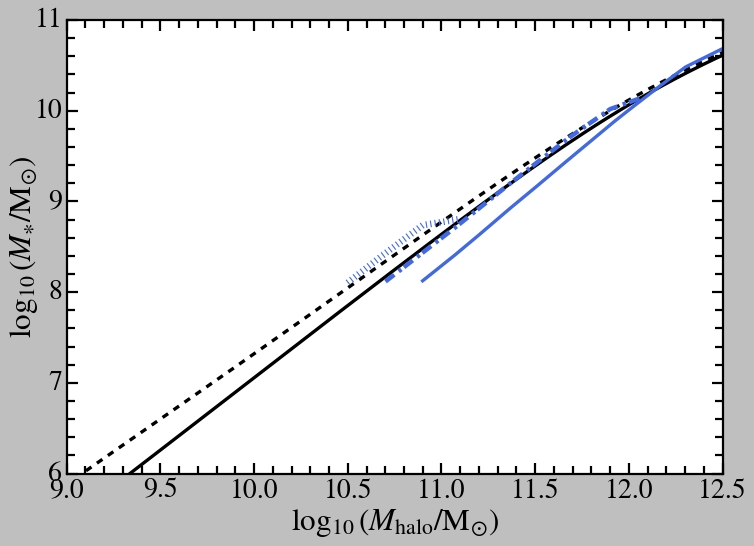

In [24]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0.11, 0.12, 0.82, 0.81])

fmhalo_to_mstar, fmhalo_to_mstarmean, (mhalo_grid, mstar, mstar_mean) = prepare_mstar_mhalo_relation(parameters_std, delta_sigma=0.0, fsfe = 1.)

ax.plot(np.log10(mhalo_grid), np.log10(mstar), 'k-', lw=3)
ax.plot(np.log10(mhalo_grid), np.log10(mstar_mean), 'k--', lw=3)

leg = plt.legend(fontsize=20, loc=2, frameon=False)#, framealpha=1); leg.get_frame().set_linewidth(0)

plt.xlabel(r'$\log_{10}{(M_{\rm halo}/{\rm M}_{\odot})}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(M_{\ast}/{\rm M}_{\odot})}$", fontsize=28, labelpad=-5)
# set the tick size of the x-axis and y-axis
#plt.text(0.84, 0.9, rf"$z={redshift}$", fontsize=25, transform = plt.gca().transAxes)

f = np.genfromtxt("./theory_data/UM19_Mstar_Mhalo.dat", names=True)
sel = f['z'] == 4
plt.plot(f['Mhalo'][sel], f['Mstar'][sel], '-', lw=3, color='royalblue', label=r"$\rm Behroozi+19$")
sel = f['z'] == 7
plt.plot(f['Mhalo'][sel], f['Mstar'][sel], '-.', dashes=(10,5,3,3), lw=4, color='royalblue')
sel = f['z'] == 10
plt.plot(f['Mhalo'][sel], f['Mstar'][sel], ':', lw=6, color='royalblue')

plt.xlim(9, 12.5); plt.ylim(6, 11); 
#plt.yscale('log')
#plt.yticks([0.01, 0.1, 0.5], [r'$1\%$', r'$10\%$', r'$50\%$'])
plt.gca().tick_params(labelsize=25, size=10)
#plt.savefig(f"figures/star_formation_efficiency.pdf")
plt.show()

In [25]:
def compute_cumulative_stellar_mass(logmhalo, phihalo, mapping_function):
    # mapping_function: logMhalo -> logMstar
    dlogmh = np.abs(logmhalo[1] - logmhalo[0]) # a constant
    halo_number_density = phihalo * dlogmh #  [Mpc^-3]
    mstar_of_halo = 10**mapping_function(logmhalo) # [Msun]

    cum_mstar_arr = np.cumsum( (halo_number_density * mstar_of_halo)[::-1] )[::-1]
    cum_mhalo_arr = np.cumsum( (halo_number_density * 10**logmhalo)[::-1] )[::-1]
    #for i in range(len(phihalo)):
        #cum_mstar_arr[i] = np.sum(halo_number_density[i:] * mstar_of_halo[i:])
        #cum_mhalo_arr[i] = np.sum(halo_number_density[i:] * 10**logmhalo[i:])
    return np.log10(mstar_of_halo), cum_mhalo_arr, cum_mstar_arr # [Msun/Mpc^3]

factor_from_Salpeter_to_Chabrier = 0.63

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/183026769.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/183026769.py:18: RuntimeWarning: divide by zero encountered in log10
  np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/183026769.py:21: RuntimeWarning: divide by zero encountered in log10
  y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix),
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/183026769.py:36: RuntimeWarning: divide by zero encountered in log10
  np.log10(cum_mstar_arr

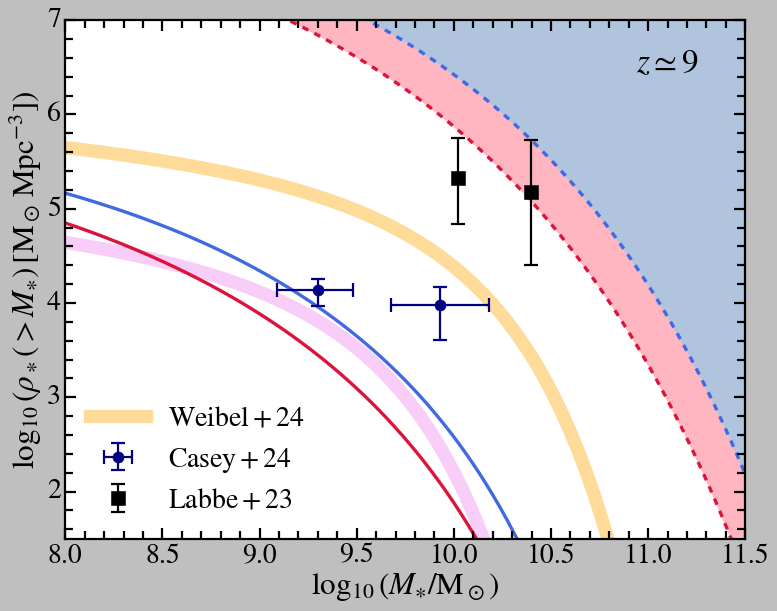

In [27]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

########
redshift = 9
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)

_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_std, delta_sigma=0.0, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3)

###########
eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix), 
         np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix),
        y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), 
        y2= 8,
        color='lightpink', edgecolor='lightpink',  alpha=1, zorder = -2)

##################
#EDE
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_ede, delta_sigma=-0.4, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

fcorr_mstar = hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede)/2.5
fcorr_nden  = - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede)

plt.plot(mstar_arr + fcorr_mstar, 
         np.log10(cum_mstar_arr) + fcorr_mstar + fcorr_nden, 
         '-', color='royalblue', lw=3)

########### 
eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
         np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + + fcorr_mstar + fcorr_nden, 
         '--', color='royalblue', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
        y1=np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + fcorr_mstar + fcorr_nden,
        y2= 8,
        color='lightsteelblue', edgecolor='lightsteelblue',  alpha=1, zorder = -1)

### observations
f = np.genfromtxt("./observational_data/Casey2024_MassiveGal_sum.dat", names=True)
sel = f['z'] == 10
plt.errorbar(f['Mstar'][sel], f['Phi'][sel], xerr=(f['Mstar'][sel] - f['left'][sel], f['right'][sel] - f['Mstar'][sel]),
             yerr=(f['Phi'][sel] - f['lo'][sel], f['up'][sel] - f['Phi'][sel]), 
             marker = 'o', linestyle='none', color='navy', mec='navy', capthick=2, capsize=6, ms=10,
             label=r"$\rm Casey+24$")

f = np.genfromtxt("./observational_data/Labbe2023_MassiveGal.dat", names=True)
sel = f['z'] == 9
plt.errorbar(f['Mstar'][sel], f['Phi'][sel] + np.log10(factor_from_Salpeter_to_Chabrier), yerr=(f['Phi'][sel] - f['Philo'][sel], f['Phiup'][sel] - f['Phi'][sel]), 
             marker = 's', linestyle='none', color='k', mec='k', capthick=2, capsize=6, ms=12,
             label=r"$\rm Labbe+23$")


alpha = -2.0;  Phis = 10**(-5.12); Ms = 10**9.5
mlim = 10**np.linspace(8, 12, 101)
plt.plot(np.log10(mlim), np.log10(cumulative(mlim, Phis, Ms, alpha)) + np.log10(factor_from_Salpeter_to_Chabrier), 
         '-', lw=12, color='violet', alpha=0.4, zorder=-5)

alpha = -2.0;  Phis = 10**(-4.93); Ms = 10**10.0
mlim = 10**np.linspace(8, 12, 101)
plt.plot(np.log10(mlim), np.log10(cumulative(mlim, Phis, Ms, alpha)) + np.log10(0.63/0.67), 
         '-', lw=12, color='orange', alpha=0.4, zorder=-5, label=r"$\rm Weibel+24$")

##################
leg = plt.legend(fontsize=25, loc=3, frameon=False, numpoints=1)
plt.xlabel(r'$\log_{10}{(M_{\ast}/{\rm M}_\odot)}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\rho_\ast(>M_{\ast})\,[{\rm M}_\odot\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(8, 11.5); plt.ylim(1.5, 7); 
plt.gca().tick_params(labelsize=25, size=10)
#plt.show()
plt.savefig(f"./figures/stellar_mass_density_{redshift}.pdf")

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/524906585.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3, label=r"$\Lambda{\rm CDM}$")
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/524906585.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/524906585.py:20: RuntimeWarning: divide by zero encountered in log10
  y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix),
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/524906585.py:35: RuntimeWarning: divide by zero encountered in l

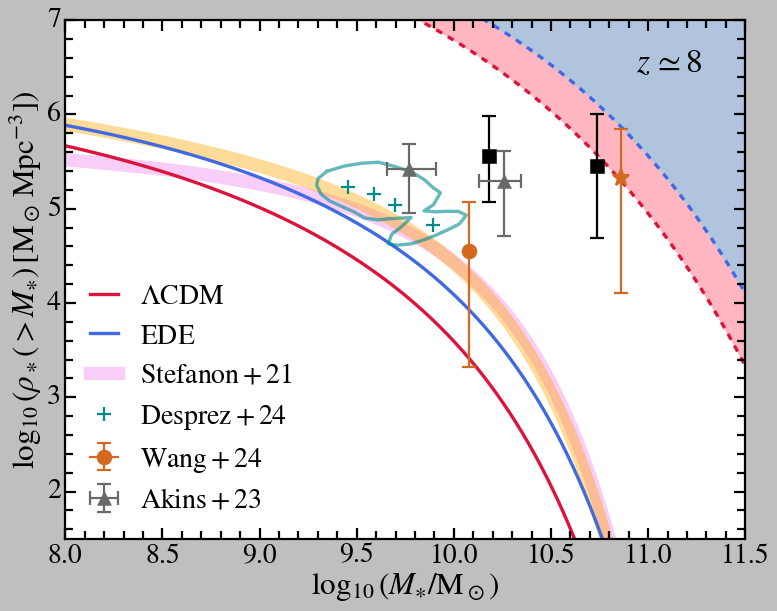

In [35]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

########
redshift = 7.5
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)

_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_std, delta_sigma=0.0, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3, label=r"$\Lambda{\rm CDM}$")

eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix), 
         np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix),
        y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), 
        y2= 8,
        color='lightpink', edgecolor='lightpink',  alpha=1, zorder = -2)

##################
#EDE
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_ede, delta_sigma=-0.4, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

fcorr_mstar = hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede)/2.5
fcorr_nden  = - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede)

plt.plot(mstar_arr + fcorr_mstar, 
         np.log10(cum_mstar_arr) + fcorr_mstar + fcorr_nden, 
         '-', color='royalblue', lw=3, label=r"$\rm EDE$")

eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
         np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + + fcorr_mstar + fcorr_nden, 
         '--', color='royalblue', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
        y1=np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + fcorr_mstar + fcorr_nden,
        y2= 8,
        color='lightsteelblue', edgecolor='lightsteelblue',  alpha=1, zorder = -1)

### observations
f = np.genfromtxt("./observational_data/Desprez2024_MassiveGal.dat", names=True)
sel = f['type'] == 0
plt.errorbar(f['Mstar'][sel], f['Phi'][sel], 
             marker = '+', linestyle='none', color='darkcyan', mec='darkcyan', ms=12, mew=2,
             label=r"$\rm Desprez+24$")
sel = f['type'] == 1
plt.plot(f['Mstar'][sel], f['Phi'][sel], '-', color='darkcyan', mec='darkcyan', lw=3, alpha=0.6)

##
f = np.genfromtxt("./observational_data/Labbe2023_MassiveGal.dat", names=True)
sel = f['z'] == 8
plt.errorbar(f['Mstar'][sel], f['Phi'][sel] + np.log10(factor_from_Salpeter_to_Chabrier), yerr=(f['Phi'][sel] - f['Philo'][sel], f['Phiup'][sel] - f['Phi'][sel]), 
             marker = 's', linestyle='none', color='k', mec='k', capthick=2, capsize=6, ms=12)

alpha = -1.82;  Phis = 10**(-4.69); Ms = 10**9.98
mlim = 10**np.linspace(8, 12, 101)
plt.plot(np.log10(mlim), np.log10(cumulative(mlim, Phis, Ms, alpha)) + np.log10(factor_from_Salpeter_to_Chabrier), 
         '-', lw=12, color='violet', alpha=0.4, zorder=-5, label=r"$\rm Stefanon+21$")

alpha = -2.16;  Phis = 10**(-4.86); Ms = 10**10.0
mlim = 10**np.linspace(8, 12, 101)
plt.plot(np.log10(mlim), np.log10(cumulative(mlim, Phis, Ms, alpha)) + np.log10(0.63/0.67), 
         '-', lw=12, color='orange', alpha=0.4, zorder=-5)

##
plt.errorbar(10.07681, 4.54678, yerr=([4.54678 - 3.32218], [5.07004 - 4.54678]), marker='o', 
        color='chocolate', mec='chocolate', ms=12, mew=2, lw=2, capsize=6, capthick=2, label=r"$\rm Wang+24$")

plt.errorbar(10.85853, 5.32855, yerr=([5.32855 - 4.10212], [5.84263 - 5.32855]), marker='*', 
        color='chocolate', mec='chocolate', ms=16, mew=2, lw=2, capsize=6, capthick=2)

##
f = np.genfromtxt("./observational_data/Akins2023_MassiveGal.dat", names=True)
plt.errorbar(f['logMstar'], f['Phi'] + np.log10(0.63/0.67), yerr=(f['Phi'] - f['lo'], f['up'] - f['Phi']), 
             xerr = (f['logMstar'] - f['left'], f['right'] - f['logMstar']),
             marker = '^', linestyle='none', color='dimgray', mec='dimgray', capthick=2, capsize=6, ms=12, label=r"$\rm Akins+23$")

##################
leg = plt.legend(fontsize=25, loc=3, frameon=False, numpoints=1, handlelength=1.)
plt.xlabel(r'$\log_{10}{(M_{\ast}/{\rm M}_\odot)}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\rho_\ast(>M_{\ast})\,[{\rm M}_\odot\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\,\simeq{8}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(8, 11.5); plt.ylim(1.5, 7); 
plt.gca().tick_params(labelsize=25, size=10)
#plt.show()
plt.savefig(f"./figures/stellar_mass_density_{redshift}.pdf")

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_74930/2273323868.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_74930/2273323868.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_74930/2273323868.py:20: RuntimeWarning: divide by zero encountered in log10
  y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix),
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_74930/2273323868.py:35: RuntimeWarning: divide by zero encountered in log10
  np.log10(c

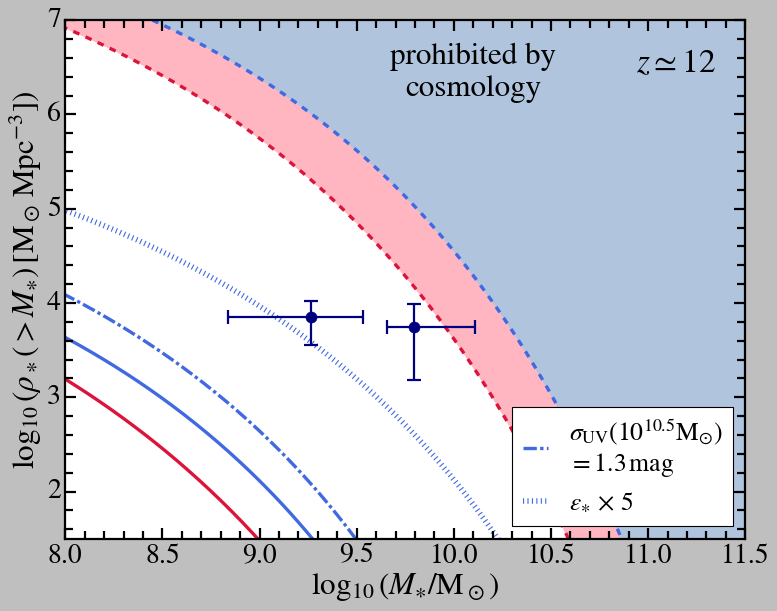

In [16]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

########
redshift = 12
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)

_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_std, delta_sigma=0.3, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3)

eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix), 
         np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix),
        y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), 
        y2= 8,
        color='lightpink', edgecolor='lightpink',  alpha=1, zorder = -2)

##################
#EDE
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_ede, delta_sigma=-0.1, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

fcorr_mstar = hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede)/2.5
fcorr_nden  = - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede)

plt.plot(mstar_arr + fcorr_mstar, 
         np.log10(cum_mstar_arr) + fcorr_mstar + fcorr_nden, 
         '-', color='royalblue', lw=3)

# two variants
_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_ede, delta_sigma=0.4, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)
fcorr_mstar = hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede)/2.5
fcorr_nden  = - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede)
plt.plot(mstar_arr + fcorr_mstar, 
         np.log10(cum_mstar_arr) + fcorr_mstar + fcorr_nden, 
         '-.', dashes=(12,3,3,3), color='royalblue', lw=3, label=r"$\sigma_{\rm UV}(10^{10.5}{\rm M}_{\odot})$" + '\n' + r"$=1.3\,{\rm mag}$")

_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_ede, delta_sigma=-0.1, fsfe = 5.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)
fcorr_mstar = hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede)/2.5
fcorr_nden  = - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede)
plt.plot(mstar_arr + fcorr_mstar, 
         np.log10(cum_mstar_arr) + fcorr_mstar + fcorr_nden, 
         ':', color='royalblue', lw=5, label=r"$\epsilon_{\ast}\,\times\,5$")

eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
         np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + + fcorr_mstar + fcorr_nden, 
         '--', color='royalblue', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
        y1=np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + fcorr_mstar + fcorr_nden,
        y2= 8,
        color='lightsteelblue', edgecolor='lightsteelblue',  alpha=1, zorder = -1)

### observations
f = np.genfromtxt("./observational_data/Casey2024_MassiveGal_sum.dat", names=True)
sel = f['z'] == 12
plt.errorbar(f['Mstar'][sel], f['Phi'][sel], xerr=(f['Mstar'][sel] - f['left'][sel], f['right'][sel] - f['Mstar'][sel]),
             yerr=(f['Phi'][sel] - f['lo'][sel], f['up'][sel] - f['Phi'][sel]), 
             marker = 'o', linestyle='none', color='navy', mec='navy', capthick=2, capsize=6, ms=10)

plt.text(0.6, 0.9, "prohibited by\n" + "cosmology", color='k', fontsize=28, ha='center', va='center', transform = plt.gca().transAxes)

leg = plt.legend(fontsize=23, loc=4, frameon=True, numpoints=1, handlelength=1.)
plt.xlabel(r'$\log_{10}{(M_{\ast}/{\rm M}_\odot)}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\rho_\ast(>M_{\ast})\,[{\rm M}_\odot\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(8, 11.5); plt.ylim(1.5, 7); 
plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"./figures/stellar_mass_density_{redshift}.pdf")

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/4009072159.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3, label=r"$\Lambda{\rm CDM}$")
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/4009072159.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/4009072159.py:20: RuntimeWarning: divide by zero encountered in log10
  y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix),
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_764/4009072159.py:35: RuntimeWarning: divide by zero encountered 

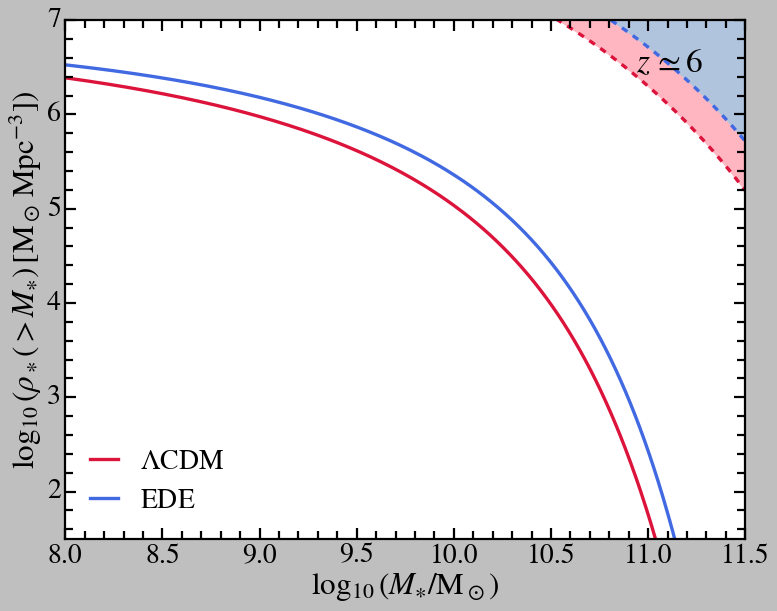

In [59]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

########
redshift = 6
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)

_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_std, delta_sigma=0.0, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

plt.plot(mstar_arr, np.log10(cum_mstar_arr), '-', color='crimson', lw=3, label=r"$\Lambda{\rm CDM}$")

eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix), 
         np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), '--', color='crimson', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_std['fbaryon']*eps_fix),
        y1=np.log10(cum_mhalo_arr * parameters_std['fbaryon']*eps_fix), 
        y2= 8,
        color='lightpink', edgecolor='lightpink',  alpha=1, zorder = -2)

##################
#EDE
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
_, fmhalo_to_mstarmean, _ = prepare_mstar_mhalo_relation(parameters_ede, delta_sigma=-0.4, fsfe = 1.)
mstar_arr, cum_mhalo_arr, cum_mstar_arr = compute_cumulative_stellar_mass(mhalo_arr, phi_halo_arr, fmhalo_to_mstarmean)

fcorr_mstar = hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede)/2.5
fcorr_nden  = - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede)

plt.plot(mstar_arr + fcorr_mstar, 
         np.log10(cum_mstar_arr) + fcorr_mstar + fcorr_nden, 
         '-', color='royalblue', lw=3, label=r"$\rm EDE$")

eps_fix = 1
plt.plot(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
         np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + + fcorr_mstar + fcorr_nden, 
         '--', color='royalblue', lw=3)

plt.fill_between(mhalo_arr + np.log10(parameters_ede['fbaryon']*eps_fix) + fcorr_mstar, 
        y1=np.log10(cum_mhalo_arr * parameters_ede['fbaryon']*eps_fix) + fcorr_mstar + fcorr_nden,
        y2= 8,
        color='lightsteelblue', edgecolor='lightsteelblue',  alpha=1, zorder = -1)

##################
leg = plt.legend(fontsize=25, loc=3, frameon=False, numpoints=1, handlelength=1.)
plt.xlabel(r'$\log_{10}{(M_{\ast}/{\rm M}_\odot)}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\rho_\ast(>M_{\ast})\,[{\rm M}_\odot\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\,\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(8, 11.5); plt.ylim(1.5, 7); 
plt.gca().tick_params(labelsize=25, size=10)
#plt.show()
plt.savefig(f"./figures/stellar_mass_density_{redshift}.pdf")

### UV variability

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_81535/4197836302.py:38: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  f = np.genfromtxt("./theory_data/K2024_sigmaUV_sim.dat", names=True, dtype=None)


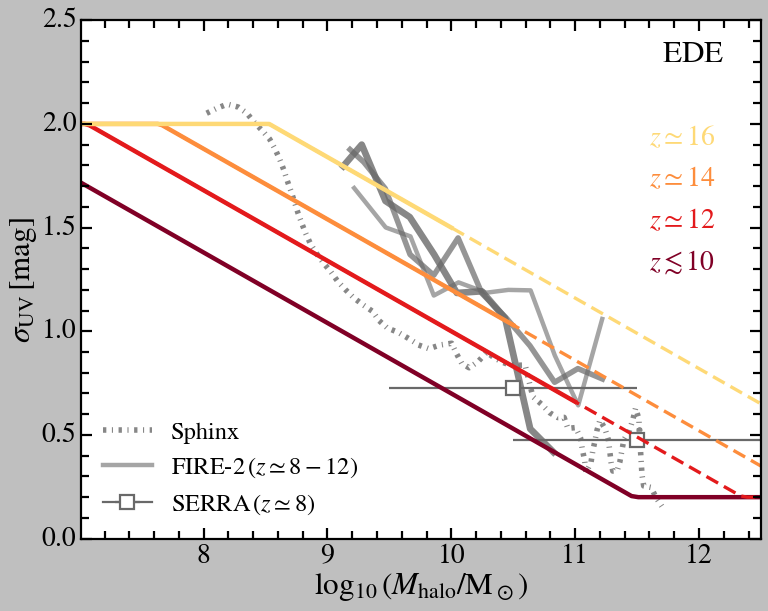

In [9]:
colorlist_default = ["#fed976", "#fd8d3c", "#e31a1c", "#800026"]
colorlist_default2= ["#bfd3e6", "#8c96c6", "#88419d", "#4d004b"]
colorlist_default3= ["#deebf7", "#9ecae1", "#4292c6", "#08519c"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

x = np.linspace(7, 12.5, 101)

l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, -0.4), '-', c=colorlist_default[3], lw=4)

l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, -0.1), '--', dashes=(12,6), c=colorlist_default[2], lw=3)
xvalid = np.linspace(7, 11.0, 101)
plt.plot(xvalid, vab.sigma_uv_vs_mhalo_alt2(xvalid, 0.2, -0.1), '-', c=colorlist_default[2], lw=4)

l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.1), '--', dashes=(12,6), c=colorlist_default[1], lw=3)
xvalid = np.linspace(7, 10.5, 101)
plt.plot(xvalid, vab.sigma_uv_vs_mhalo_alt2(xvalid, 0.2, 0.1), '-', c=colorlist_default[1], lw=4)

l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.4), '--', dashes=(12,6), c=colorlist_default[0], lw=3)
xvalid = np.linspace(7, 10.0, 101)
plt.plot(xvalid, vab.sigma_uv_vs_mhalo_alt2(xvalid, 0.2, 0.4), '-', c=colorlist_default[0], lw=4)

plt.text(11.7 , 2.3, r"$\rm EDE$", fontsize=28, color='k')

plt.text(11.6, 1.3, r"$z\,\lesssim\,10$", fontsize=25, color=colorlist_default[3])
plt.text(11.6, 1.5, r"$z \simeq 12$", fontsize=25, color=colorlist_default[2])
plt.text(11.6, 1.7, r"$z \simeq 14$", fontsize=25, color=colorlist_default[1])
plt.text(11.6, 1.9, r"$z \simeq 16$", fontsize=25, color=colorlist_default[0])

#legend1 = plt.legend([l1,l2,l3,l4,l5,l6], [r"$\Lambda{\rm CDM},\,z\simeq6-10$", r"$\Lambda{\rm CDM},\,z\simeq 12$", r"$\Lambda{\rm CDM},\,z\simeq 16$", 
#                                     r"${\rm EDE},\,z\simeq 6-10$", r"${\rm EDE},\,z\simeq 12$", r"${\rm EDE},\,z\simeq 16$"], loc=3, fontsize=22)

#x = np.linspace(8.2, 11.2, 101)
#plt.plot(x, vab.sigma_uv_vs_mhalo_firebox(x, mode='UVint'), '--', c='dimgray', lw=4, dashes=(12,6), label='FIREbox', zorder=-3)
#plt.plot(x, sigma_uv_vs_mhalo_firebox(x, mode='SFR100'), '--', c='cyan', lw=3)

f = np.genfromtxt("./theory_data/K2024_sigmaUV_sim.dat", names=True, dtype=None)
tag = f['tag'].astype(str)
sorting = np.argsort(f['Mhalo'][tag=='sphinx'])
plt.plot(f['Mhalo'][tag=='sphinx'][sorting], f['sigmaUV'][tag=='sphinx'][sorting], '-.', lw=5, zorder=-2, 
         color='dimgray', alpha=0.8, label='Sphinx')
#plt.plot(f['Mhalo'][tag=='fire'], f['sigmaUV'][tag=='fire'], '--', color='navy', alpha=0.8, lw=5,  zorder=-2, label='FIRE-2 (in K24)')

f = np.genfromtxt("./theory_data/Sun2023_sigmaUV_digit.dat", names=True)
x = (f['Mhalolo'] + f['Mhaloup'])/2
y = (f['Muvup'] - f['Muvlo'])/1.6445/2.
tag = f['z']
plt.plot(x[tag==8], y[tag==8], '-', lw=4, alpha=0.6, zorder=-2, color='dimgray', label='FIRE-2'+r"$\,(z\simeq 8-12)$")
tag = f['z']
plt.plot(x[tag==10], y[tag==10], '-', lw=5, alpha=0.7, zorder=-2, color='dimgray')
tag = f['z']
plt.plot(x[tag==12], y[tag==12], '-', lw=6, alpha=0.8, zorder=-2, color='dimgray')

#f = np.genfromtxt("./theory_data/Gelli2024_sigmaUV_sim.dat", names=True)
#tag = f['z']

# SERRA
plt.errorbar([10.5],[0.29*2.5], xerr=1, marker='s', ms=12, mew=2, lw=2, capsize=0, zorder=-1, color='dimgray', mfc='white', mec='dimgray', label=r'${\rm SERRA}\,(z\simeq 8)$') 
plt.errorbar([11.5],[0.19*2.5], xerr=1, marker='s', ms=12, mew=2, lw=2, capsize=0, zorder=-1, color='dimgray', mfc='white', mec='dimgray')

# FFB
#plt.errorbar(9.7, 1.69, xerr=0.4, yerr=0, marker='o', mfc='silver', mew=2, ms=15, lw=2, capsize=6, capthick=2, color='gray', mec='gray', zorder=-10, label=r'${\rm FFB}\,(z\simeq 12 - 16)$')
#plt.errorbar(9.7, 1.69, xerr=0.4, yerr=0, xlolims=True, marker='o', mfc='silver', mew=2, ms=15, lw=0, capsize=6, capthick=2, color='gray', mec='gray', zorder=-9)

# MS scatter
#plt.errorbar([12.0],[0.2*2.5], xerr=0.5, marker='s', ms=0, mew=2, lw=6, capsize=0, zorder=-1, color='navy')

# obs. Ciesla+2023
#plt.errorbar([11],[1.2], xerr=1, yerr=0.1, marker='o', ms=12, mew=2, lw=2, capsize=0, zorder=-1, color='navy', mfc='white', mec='navy', label=r'${\rm Ciesla+24}$') 

leg = plt.legend(fontsize=22, loc=3, frameon=False)#, bbox_to_anchor=(1.02, 0.97))
#ax.add_artist(legend1)
plt.xlabel(r'$\log_{10}{(M_{\rm halo}/{\rm M}_\odot)}$', fontsize=28)
plt.ylabel(r"$\sigma_{\rm UV}\,[{\rm mag}]$", fontsize=28)

#plt.text(0.84, 0.9, rf"$z\,\approx{redshift}$", fontsize=30, transform = plt.gca().transAxes)
plt.xlim(7.01, 12.5); plt.ylim(0, 2.5); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/sigma_uv_vs_mhalo_v2_ede.pdf")

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_81535/373552131.py:48: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  f = np.genfromtxt("./theory_data/K2024_sigmaUV_sim.dat", names=True, dtype=None)


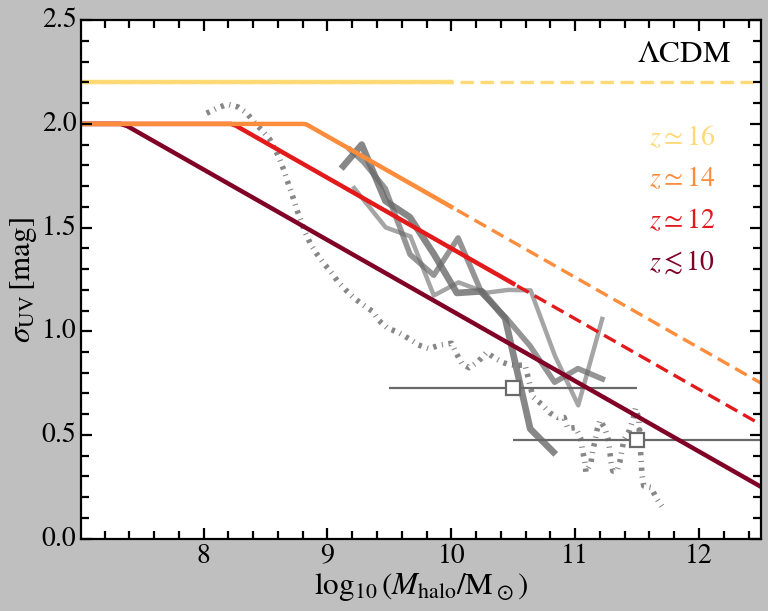

In [10]:
colorlist_default = ["#fed976", "#fd8d3c", "#e31a1c", "#800026"]
colorlist_default2= ["#bfd3e6", "#8c96c6", "#88419d", "#4d004b"]
colorlist_default3= ["#deebf7", "#9ecae1", "#4292c6", "#08519c"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

def sigma_uv_vs_mhalo_alt5(log_mhalo, yfloor, delta, ymax=2.2, xbreak = 9.0):
    y = 1.3 - 0.8 * (log_mhalo - 10) + delta

    if yfloor + delta > ymax:
        y = np.ones_like(log_mhalo) * (yfloor + delta)
        return y
    yfloor = max(yfloor, 0)
    y[y<yfloor] = yfloor
    y[y>ymax] = ymax
    return y

x = np.linspace(7, 12.5, 101)
l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.0), '-', c=colorlist_default[3], lw=4)

l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.3), '--', dashes=(12,6), c=colorlist_default[2], lw=3)
xvalid = np.linspace(7, 10.5, 101)
plt.plot(xvalid, vab.sigma_uv_vs_mhalo_alt2(xvalid, 0.2, 0.3), '-', c=colorlist_default[2], lw=4)

l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.5), '--', dashes=(12,6), c=colorlist_default[1], lw=3)
xvalid = np.linspace(7, 10, 101)
plt.plot(xvalid, vab.sigma_uv_vs_mhalo_alt2(xvalid, 0.2, 0.5), '-', c=colorlist_default[1], lw=4)

l4, = plt.plot(x, vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 2.0), '--', dashes=(12,6), c=colorlist_default[0], lw=3)
xvalid = np.linspace(7, 10, 101)
plt.plot(xvalid, vab.sigma_uv_vs_mhalo_alt2(xvalid, 0.2, 2.0), '-', c=colorlist_default[0], lw=4)

plt.text(11.5 , 2.3, r"$\Lambda{\rm CDM}$", fontsize=28, color='k')

plt.text(11.6, 1.3, r"$z\,\lesssim\,10$", fontsize=25, color=colorlist_default[3])
plt.text(11.6, 1.5, r"$z \simeq 12$", fontsize=25, color=colorlist_default[2])
plt.text(11.6, 1.7, r"$z \simeq 14$", fontsize=25, color=colorlist_default[1])
plt.text(11.6, 1.9, r"$z \simeq 16$", fontsize=25, color=colorlist_default[0])

#legend1 = plt.legend([l1,l2,l3,l4,l5,l6], [r"$\Lambda{\rm CDM},\,z\simeq6-10$", r"$\Lambda{\rm CDM},\,z\simeq 12$", r"$\Lambda{\rm CDM},\,z\simeq 16$", 
#                                     r"${\rm EDE},\,z\simeq 6-10$", r"${\rm EDE},\,z\simeq 12$", r"${\rm EDE},\,z\simeq 16$"], loc=3, fontsize=22)

#x = np.linspace(8.2, 11.2, 101)
#plt.plot(x, vab.sigma_uv_vs_mhalo_firebox(x, mode='UVint'), '--', c='dimgray', lw=4, dashes=(12,6), label='FIREbox', zorder=-3)
#plt.plot(x, sigma_uv_vs_mhalo_firebox(x, mode='SFR100'), '--', c='cyan', lw=3)

f = np.genfromtxt("./theory_data/K2024_sigmaUV_sim.dat", names=True, dtype=None)
tag = f['tag'].astype(str)
sorting = np.argsort(f['Mhalo'][tag=='sphinx'])
plt.plot(f['Mhalo'][tag=='sphinx'][sorting], f['sigmaUV'][tag=='sphinx'][sorting], '-.', lw=5, zorder=-2, 
         color='dimgray', alpha=0.8, label='Sphinx')
#plt.plot(f['Mhalo'][tag=='fire'], f['sigmaUV'][tag=='fire'], '-', color='navy', alpha=0.8, lw=5,  zorder=-2, label='FIRE-2 (in K24)')

f = np.genfromtxt("./theory_data/Sun2023_sigmaUV_digit.dat", names=True)
x = (f['Mhalolo'] + f['Mhaloup'])/2
y = (f['Muvup'] - f['Muvlo'])/1.6445/2.
tag = f['z']
plt.plot(x[tag==8], y[tag==8], '-', lw=4, alpha=0.6, zorder=-2, color='dimgray', label='FIRE-2'+r"$\,(z\simeq 8-12)$")
tag = f['z']
plt.plot(x[tag==10], y[tag==10], '-', lw=5, alpha=0.7, zorder=-2, color='dimgray')
tag = f['z']
plt.plot(x[tag==12], y[tag==12], '-', lw=6, alpha=0.8, zorder=-2, color='dimgray')

# SERRA
plt.errorbar([10.5],[0.29*2.5], xerr=1, marker='s', ms=12, mew=2, lw=2, capsize=0, zorder=-1, color='dimgray', mfc='white', mec='dimgray', label=r'${\rm SERRA}\,(z\simeq 8)$') 
plt.errorbar([11.5],[0.19*2.5], xerr=1, marker='s', ms=12, mew=2, lw=2, capsize=0, zorder=-1, color='dimgray', mfc='white', mec='dimgray')

# FFB
#plt.errorbar(9.7, 1.69, xerr=0.4, yerr=0, marker='o', mfc='silver', mew=2, ms=15, lw=2, capsize=6, capthick=2, color='gray', mec='gray', zorder=-10, label=r'${\rm FFB}\,(z\simeq 12 - 16)$')
#plt.errorbar(9.7, 1.69, xerr=0.4, yerr=0, xlolims=True, marker='o', mfc='silver', mew=2, ms=15, lw=0, capsize=6, capthick=2, color='gray', mec='gray', zorder=-9)

# obs. Ciesla+2023
#plt.errorbar([11],[1.2], xerr=1, yerr=0.1, marker='o', ms=12, mew=2, lw=2, capsize=0, zorder=-1, color='navy', mfc='white', mec='navy', label=r'${\rm Ciesla+24}$') 

#leg = plt.legend(fontsize=22, loc=3, frameon=False)#, bbox_to_anchor=(1.02, 0.97))
#ax.add_artist(legend1)
plt.xlabel(r'$\log_{10}{(M_{\rm halo}/{\rm M}_\odot)}$', fontsize=28)
plt.ylabel(r"$\sigma_{\rm UV}\,[{\rm mag}]$", fontsize=28)

#plt.text(0.84, 0.9, rf"$z\,\approx{redshift}$", fontsize=30, transform = plt.gca().transAxes)
plt.xlim(7.01, 12.5); plt.ylim(0, 2.5); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/sigma_uv_vs_mhalo_v2.pdf")

### muv-mhalo relation & halo bias

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


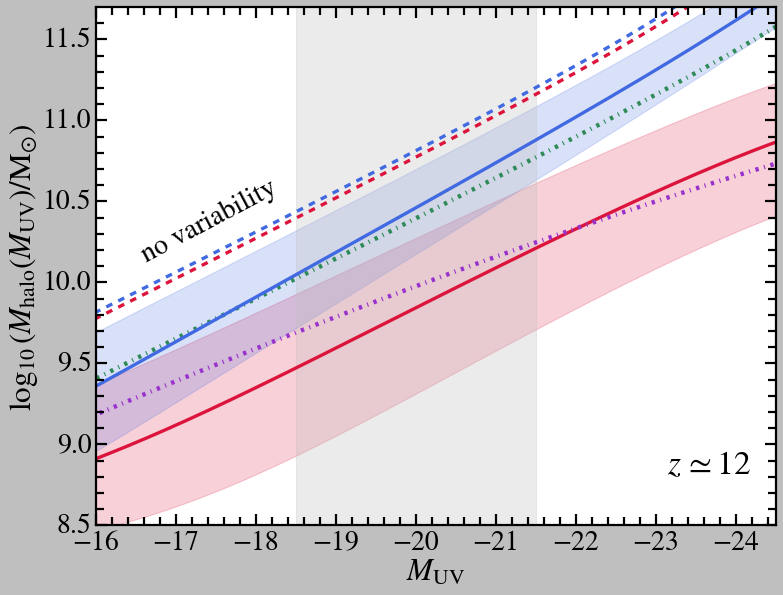

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 12
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
epsilon = "this_work" 

delta_sigma = 0.3
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, 
                                    cosmo=cosmo_std, parameters=parameters_std, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

plt.plot(muv_arr, mhalo_arr, color='crimson', linestyle='--', lw=3)

mhalo_stats = np.zeros((linking_matrix.shape[0],3))
for j in range(linking_matrix.shape[1]):
    mhalo_stats[j,:] = lf_mapping.weighted_percentile(mhalo_arr, weights = linking_matrix[:,j], percentile=[16,50,84])
plt.plot(muv_arr, mhalo_stats[:,1], color='crimson', linestyle='-', lw=3, label=r'$\Lambda{\rm CDM}$')
plt.fill_between(muv_arr, y1 = mhalo_stats[:,0], y2 = mhalo_stats[:,2], 
             color='crimson', zorder=-1, alpha=0.2)

## constant scatter as in Paper I
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = 1.5, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True)  
mhalo_stats = np.zeros((linking_matrix.shape[0],3))
for j in range(linking_matrix.shape[1]):
    mhalo_stats[j,:] = lf_mapping.weighted_percentile(mhalo_arr, weights = linking_matrix[:,j], percentile=[16,50,84])
plt.plot(muv_arr, mhalo_stats[:,1], color='darkorchid', linestyle='-.', lw=4, label=r'${\rm const.}\,\,\sigma_{\rm UV}=1.5$')

## no scatter, pure shift in SFE
sigma = 0
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = sigma, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon="vary_4", redshift=redshift, include_dust=True)  
plt.plot(muv_arr, mhalo_arr, color='seagreen', linestyle='-.', lw=4, label=r'${\rm SFE} \times 4,\,\,\sigma_{\rm UV}=0$')

## with EDE
delta_sigma = -0.1
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr_ede, phi_halo_arr_ede, 
                                    cosmo=cosmo_ede, parameters=parameters_ede, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

plt.plot(muv_arr, mhalo_arr, color='royalblue', linestyle='--', lw=3)
mhalo_stats = np.zeros((linking_matrix.shape[0],3))
for j in range(linking_matrix.shape[1]):
    mhalo_stats[j,:] = lf_mapping.weighted_percentile(mhalo_arr, weights = linking_matrix[:,j], percentile=[16,50,84])
plt.plot(muv_arr, mhalo_stats[:,1], color='royalblue', linestyle='-', lw=3, label=r'${\rm EDE}$')
plt.fill_between(muv_arr, y1 = mhalo_stats[:,0], y2 = mhalo_stats[:,2], 
             color='royalblue', zorder=-1, alpha=0.2)

plt.axvspan(-18.5, -21.5, color='silver', alpha=0.3)
plt.text(0.06, 0.51, "no variability", fontsize=25,rotation=28, transform = plt.gca().transAxes)

#leg = plt.legend(fontsize=25, loc=2, frameon=False, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(M_{\rm halo}(M_{\rm UV})/{\rm M}_{\odot})}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.1, rf"$z\,\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(8.5, 11.7); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/mhalo_muv_z={redshift}.pdf")
#plt.show()

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


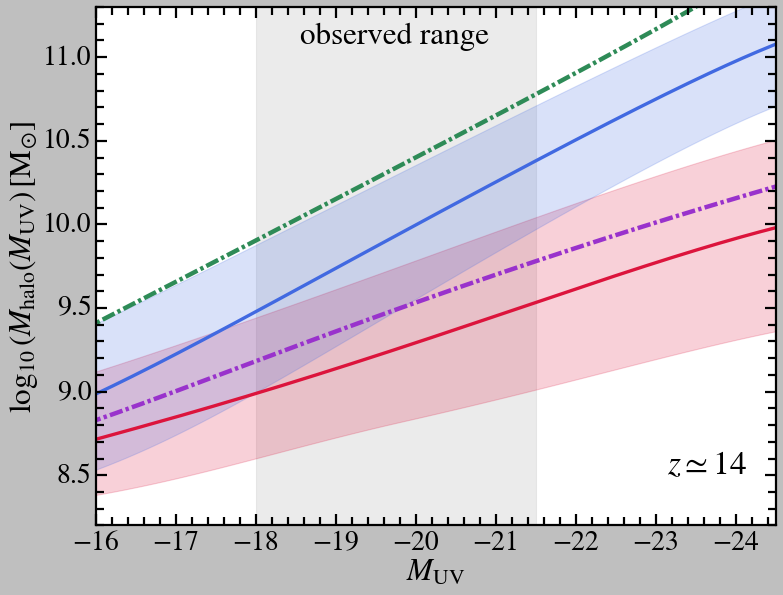

In [8]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 14
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
epsilon = "this_work" 

delta_sigma = 0.5
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, 
                                    cosmo=cosmo_std, parameters=parameters_std, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

#plt.plot(muv_arr, mhalo_arr, color='crimson', linestyle='--', lw=3)

mhalo_stats = np.zeros((linking_matrix.shape[0],3))
for j in range(linking_matrix.shape[1]):
    mhalo_stats[j,:] = lf_mapping.weighted_percentile(mhalo_arr, weights = linking_matrix[:,j], percentile=[16,50,84])
plt.plot(muv_arr, mhalo_stats[:,1], color='crimson', linestyle='-', lw=3, label=r'$\Lambda{\rm CDM}$')
plt.fill_between(muv_arr, y1 = mhalo_stats[:,0], y2 = mhalo_stats[:,2], 
             color='crimson', zorder=-1, alpha=0.2)

## constant scatter as in Paper I
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = 1.8, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True)  
mhalo_stats = np.zeros((linking_matrix.shape[0],3))
for j in range(linking_matrix.shape[1]):
    mhalo_stats[j,:] = lf_mapping.weighted_percentile(mhalo_arr, weights = linking_matrix[:,j], percentile=[16,50,84])
plt.plot(muv_arr, mhalo_stats[:,1], color='darkorchid', linestyle='-.', lw=4, dashes=(12,3,3,3),
         label=r'$\Lambda{\rm CDM}\,\,{\rm const.}\,\sigma_{\rm UV}$')

## no scatter, pure shift in SFE
sigma = 0
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon="vary_3", redshift=redshift, include_dust=True, variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.0))  
plt.plot(muv_arr, mhalo_arr, color='seagreen', linestyle='-.', lw=4,  dashes=(12,3,3,3), label=r'${\rm SFE} \times 4$')

## with EDE
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
delta_sigma = 0.1
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr_ede, phi_halo_arr_ede, 
                                    cosmo=cosmo_ede, parameters=parameters_ede, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

#plt.plot(muv_arr, mhalo_arr, color='royalblue', linestyle='--', lw=3)

mhalo_stats = np.zeros((linking_matrix.shape[0],3))
for j in range(linking_matrix.shape[1]):
    mhalo_stats[j,:] = lf_mapping.weighted_percentile(mhalo_arr, weights = linking_matrix[:,j], percentile=[16,50,84])
plt.plot(muv_arr, mhalo_stats[:,1], color='royalblue', linestyle='-', lw=3, label=r'${\rm EDE}$')
plt.fill_between(muv_arr, y1 = mhalo_stats[:,0], y2 = mhalo_stats[:,2], 
             color='royalblue', zorder=-1, alpha=0.2)

plt.axvspan(-18, -21.5, color='silver', alpha=0.3, zorder=-10)

#leg = plt.legend(fontsize=25, loc=2, frameon=False, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(M_{\rm halo}(M_{\rm UV})\,[{\rm M}_{\odot}]}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.1, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.text(0.30, 0.93, "observed range", fontsize=28, color='black', transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(8.2, 11.3); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/mhalo_muv_z={redshift}.pdf")
#plt.show()

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


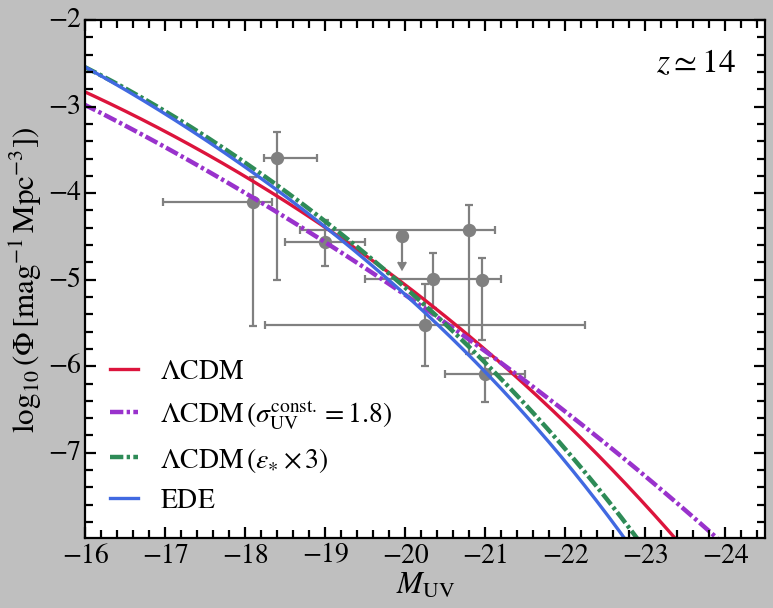

In [9]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 14
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters=parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters=parameters_ede)
epsilon = "this_work" #"H22_z7" 

muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.5))  
plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="-", label=r'$\Lambda{\rm CDM}$')

# constant scatter
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = 1.8, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True)
plt.plot(muv_arr, np.log10(phi_uv_arr), color='darkorchid', lw=4, linestyle="-.", dashes=(12, 3, 3, 3), label=r'$\Lambda{\rm CDM}\,(\sigma^{\rm const.}_{\rm UV}=1.8)$')

# no scatter, pure shift in SFE
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon="vary_3.1", redshift=redshift, include_dust=True,
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.0))
plt.plot(muv_arr, np.log10(phi_uv_arr), color='seagreen', lw=4, linestyle="-.", dashes=(12, 3, 3, 3), label=r'$\Lambda{\rm CDM}\,(\epsilon_{\ast} \times 3)$')

# EDE
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.1))  
plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), color='royalblue', lw=3, 
         linestyle="-", label=r'${\rm EDE}$')

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

leg = plt.legend(fontsize=25, loc=3, frameon=False, handlelength=1)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}_variations.pdf")

In [10]:
from colossus.lss import bias
from colossus.cosmology import cosmology

In [11]:
colossus_cosmo = cosmology.fromAstropy(cosmo_std, parameters_std['sigma8'], parameters_std['ns'], cosmo_name = 'cosmo_std')
b1 = bias.haloBias(np.array([1e10, 1e12]), model = 'tinker10', z = 0, mdef = 'vir')

colossus_cosmo = cosmology.fromAstropy(cosmo_ede, parameters_ede['sigma8'], parameters_ede['ns'], cosmo_name = 'cosmo_ede')
b2 = bias.haloBias(np.array([1e10, 1e12]), model = 'tinker10', z = 0, mdef = 'vir')

print(b1)
print(b2)

[0.67175862 0.84215425]
[0.66473747 0.81172676]


/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/colossus/cosmology/cosmology.py:3338: UserWarning: Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.
  warnings.warn('Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.')


In [12]:
def calculate_bias_at_Muv(mhalo_arr, muv_arr, linking_matrix, redshift):  
    # here mhalo_arr in unit of Msun/h
    bias_muv = np.zeros(len(muv_arr))

    if linking_matrix is not None:
        for i, muv in enumerate(muv_arr):
            weights_at_muv = linking_matrix[:,i]
            bias_halo = bias.haloBias(mhalo_arr, model = 'tinker10', z = redshift, mdef = 'vir')
            bias_muv[i] = np.sum(bias_halo * weights_at_muv)/np.sum(weights_at_muv)
    else:
        bias_muv = bias.haloBias(mhalo_arr, model = 'tinker10', z = redshift, mdef = 'vir')
    return bias_muv

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


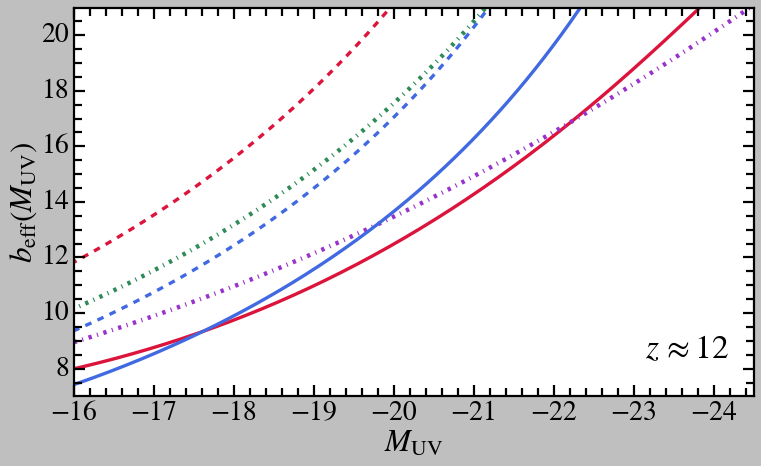

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.11, 0.14, 0.85, 0.81])

redshift = 12
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
epsilon = "this_work" 

cosmology.fromAstropy(cosmo_std, parameters_std['sigma8'], parameters_std['ns'], cosmo_name = 'cosmo_std')
delta_sigma = 0.3
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, 
                                    cosmo=cosmo_std, parameters=parameters_std, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_std['hubble'], muv_arr, None, redshift)
plt.plot(muv_arr, bias_muv, color='crimson', linestyle='--', lw=3)

bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_std['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='crimson', linestyle='-', lw=3, label=r'$\Lambda{\rm CDM}$')

## constant scatter as in Paper I
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = 1.5, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True)  
bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_std['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='darkorchid', linestyle='-.', lw=4, label=r'$\Lambda{\rm CDM}\,\,{\rm const.}\,\sigma_{\rm UV}$')

## no scatter, pure shift in SFE
sigma = 0
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = sigma, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon="vary_3", redshift=redshift, include_dust=True)  
bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_std['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='seagreen', linestyle='-.', lw=4, label=r'${\rm SFE} \times 4$')

#### now in EDE
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)

cosmology.fromAstropy(cosmo_ede, parameters_ede['sigma8'], parameters_ede['ns'], cosmo_name = 'cosmo_ede')
delta_sigma = -0.1
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr_ede, phi_halo_arr_ede, 
                                    cosmo=cosmo_ede, parameters=parameters_ede, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_ede['hubble'], muv_arr, None, redshift)
plt.plot(muv_arr, bias_muv, color='royalblue', linestyle='--', lw=3)

bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_ede['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='royalblue', linestyle='-', lw=3, label=r'${\rm EDE}$')

#plt.axvspan(-18.5, -21.5, color='silver', alpha=0.3)

#leg = plt.legend(fontsize=25, loc=4, frameon=False, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$b_{\rm eff}(M_{\rm UV})$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.1, rf"$z\,\approx{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(7, 20.99); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/bias_z={redshift}.pdf")
#plt.show()

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))
/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/colossus/cosmology/cosmology.py:3338: UserWarning: Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.
  warnings.warn('Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.')


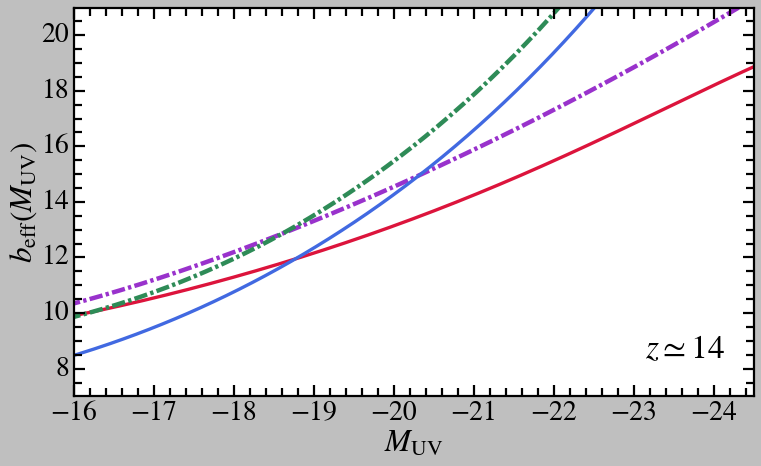

In [14]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.11, 0.14, 0.85, 0.81])

redshift = 14
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
epsilon = "this_work" 

cosmology.fromAstropy(cosmo_std, parameters_std['sigma8'], parameters_std['ns'], cosmo_name = 'cosmo_std')
delta_sigma = 0.5
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, 
                                    cosmo=cosmo_std, parameters=parameters_std, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_std['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='crimson', linestyle='-', lw=3, label=r'$\Lambda{\rm CDM}$')

## constant scatter as in Paper I
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = 1.8, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True)  
bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_std['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='darkorchid', linestyle='-.', lw=4, dashes=(12,3,3,3))

## no scatter, pure shift in SFE
sigma = 0
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon="vary_3", redshift=redshift, include_dust=True, variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.0))  
bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_std['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='seagreen', linestyle='-.', lw=4, dashes=(12,3,3,3))

#### now in EDE
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)

cosmology.fromAstropy(cosmo_ede, parameters_ede['sigma8'], parameters_ede['ns'], cosmo_name = 'cosmo_ede')
delta_sigma = 0.1
mhalo_arr, muv_arr, linking_matrix = lf_mapping.compute_mhalo_muv_relation(mhalo_arr_ede, phi_halo_arr_ede, 
                                    cosmo=cosmo_ede, parameters=parameters_ede, sigma_uv = None, 
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  

bias_muv = calculate_bias_at_Muv(10**mhalo_arr/parameters_ede['hubble'], muv_arr, linking_matrix, redshift)
plt.plot(muv_arr, bias_muv, color='royalblue', linestyle='-', lw=3, label=r'${\rm EDE}$')

#plt.axvspan(-18.5, -21.5, color='silver', alpha=0.3)

#leg = plt.legend(fontsize=25, loc=4, frameon=False, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$b_{\rm eff}(M_{\rm UV})$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.1, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(7, 20.99); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/bias_z={redshift}.pdf")
#plt.show()

In [22]:
## 
data = np.ones(10000)
data[:int(10000*(1-0.2))] = 0.02

print(np.mean(data), np.mean(np.log10(data)))

print(np.log10(10**(10.8) * ((1+16)/10)**(-6.2)) )
print(np.log10(10**(10.8) * ((1+12)/10)**(-6.2)) )

np.std(np.log10(data)) * 2.5

0.216 -1.359176003468815
9.371216687454702
10.093551215697612


1.6989700043360187

### main

In [19]:
colorlist_default = ["#fed976", "#fd8d3c", "#e31a1c", "#800026"]
colorlist_default2= ["#9ebcda","#8c96c6","#8c6bb1","#88419d","#810f7c","#4d004b"]

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


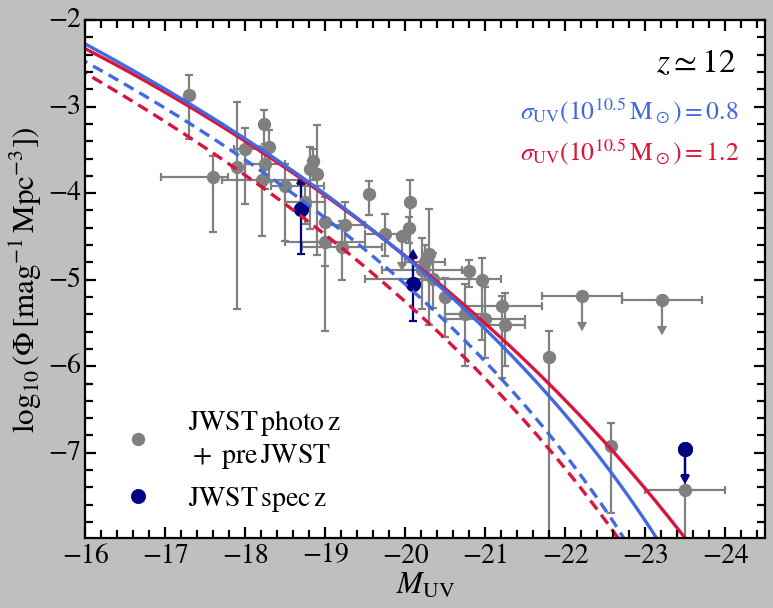

In [22]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 12
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters=parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters=parameters_ede)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default
for i, delta_sigma in enumerate([0.0, 0.3]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

colors = colorlist_default2
for i, delta_sigma in enumerate([-0.4, -0.1]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), color='royalblue', lw=3, 
         linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

'''
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon="vary_1.5", redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, -0.4))  
plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), color='cyan', 
         lw=4,  linestyle="-.", dashes=(12,3,3,3), zorder=-1)
''' 

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm JWST\,photo\,z$" + '\n' + r"$\rm +\,\,pre\,JWST$", **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm JWST\,spec\,z$", **kwargs)

plt.text(0.64, 0.81, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, -0.1)[0]:.1f}", 
         color='royalblue', fontsize=23, transform = plt.gca().transAxes)
plt.text(0.64, 0.73, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 0.3)[0]:.1f}", 
         color='crimson', fontsize=23, transform = plt.gca().transAxes)
#plt.plot([],[],'-' , c='gray', lw=1.5, label=r"$\rm with\,\,dust$")

leg = plt.legend(fontsize=25, loc=3, frameon=True, framealpha=1, numpoints=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))
/Users/xuejianshen/Desktop/high-redshift-FIRE/toy_model/utilities/observation_data.py:176: RuntimeWarning: divide by zero encountered in log10
  ylo = np.log10(f['Phi'][sel] - f['lo'][sel]) + np.log10(1e-6)


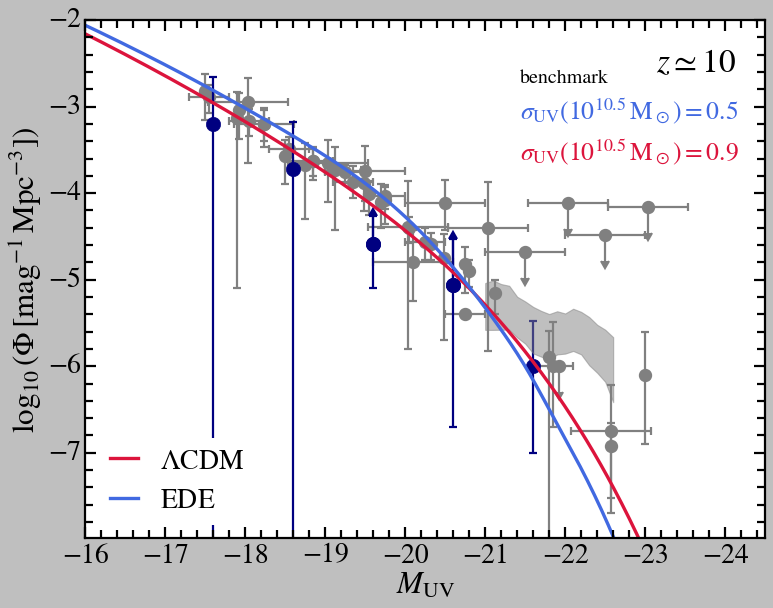

In [23]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 10
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters=parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters=parameters_ede)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default
for i, delta_sigma in enumerate([0.0]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="-")

colors = colorlist_default2
for i, delta_sigma in enumerate([-0.4]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), color='royalblue', lw=3, linestyle="-") 

#plt.plot(muv_arr, 
#         np.log10(phi_uv_arr), color='cyan', lw=4, linestyle="--", dashes=(7,4))

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -7}
obs.plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

plt.plot([],[],'-', c='crimson', lw=3, label=r"$\Lambda{\rm CDM}$")
plt.plot([],[],'-' , c='royalblue', lw=3, label=r"${\rm EDE}$")

plt.text(0.64, 0.88, 'benchmark', color='k', fontsize=18, transform = plt.gca().transAxes)
plt.text(0.64, 0.81, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, -0.4)[0]:.1f}", 
         color='royalblue', fontsize=23, transform = plt.gca().transAxes)
plt.text(0.64, 0.73, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 0.0)[0]:.1f}", 
         color='crimson', fontsize=23, transform = plt.gca().transAxes)

leg = plt.legend(fontsize=25, loc=3, frameon=True, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")
#plt.show()

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


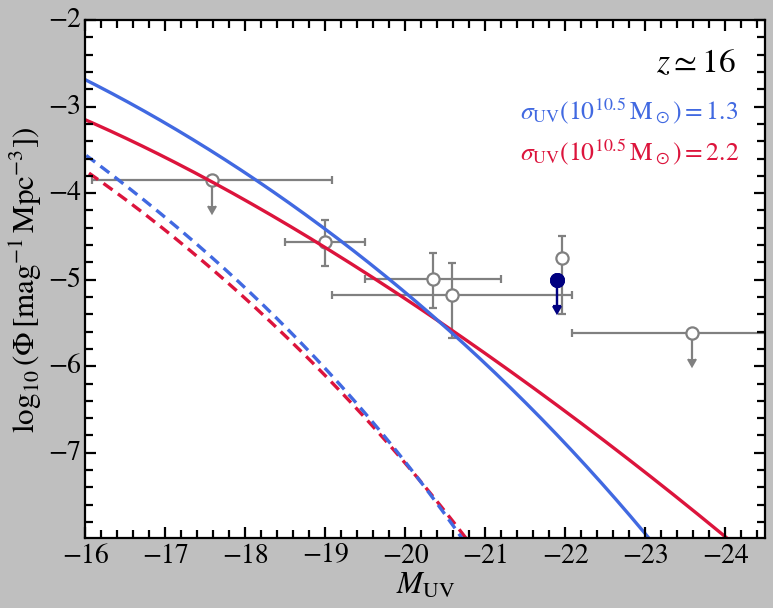

In [24]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 16
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters=parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters=parameters_ede)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default
for i, delta_sigma in enumerate([0.0, 2.0]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=False, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr, np.log10(phi_uv_arr), color="crimson", lw=3, linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

colors = colorlist_default2
for i, delta_sigma in enumerate([-0.4, 0.4]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=False, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), color='royalblue', lw=3,
         linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

kwargs = {"ms": 11,  "color": "gray", "mec": "gray", "mfc": "white", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

plt.text(0.64, 0.81, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 0.4)[0]:.1f}", 
         color='royalblue', fontsize=23, transform = plt.gca().transAxes)
plt.text(0.64, 0.73, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 2.0)[0]:.1f}", 
         color='crimson', fontsize=23, transform = plt.gca().transAxes)

#leg = plt.legend(fontsize=25, loc=3, frameon=True, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


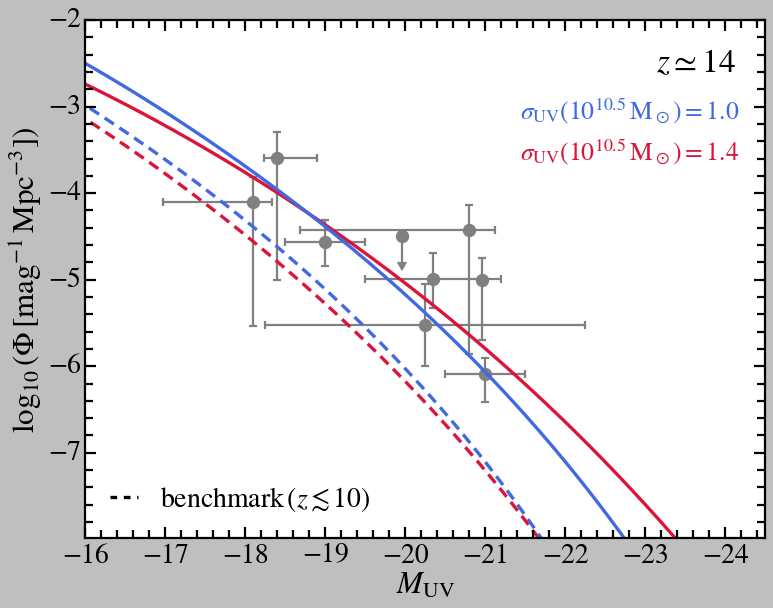

In [108]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 14
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters=parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters=parameters_ede)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default
for i, delta_sigma in enumerate([0.0, 0.5]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

colors = colorlist_default2
for i, delta_sigma in enumerate([-0.4, 0.1]):
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, delta_sigma))  
    plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), color='royalblue', lw=3, 
         linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

plt.text(0.64, 0.81, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 0.1)[0]:.1f}", 
         color='royalblue', fontsize=23, transform = plt.gca().transAxes)
plt.text(0.64, 0.73, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 0.5)[0]:.1f}", 
         color='crimson', fontsize=23, transform = plt.gca().transAxes)

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

plt.plot([],[],'--', c='black', lw=3, label=r"${\rm benchmark}\,(z\,\lesssim\, 10)$")

leg = plt.legend(fontsize=25, loc=3, frameon=True, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

### additional tests

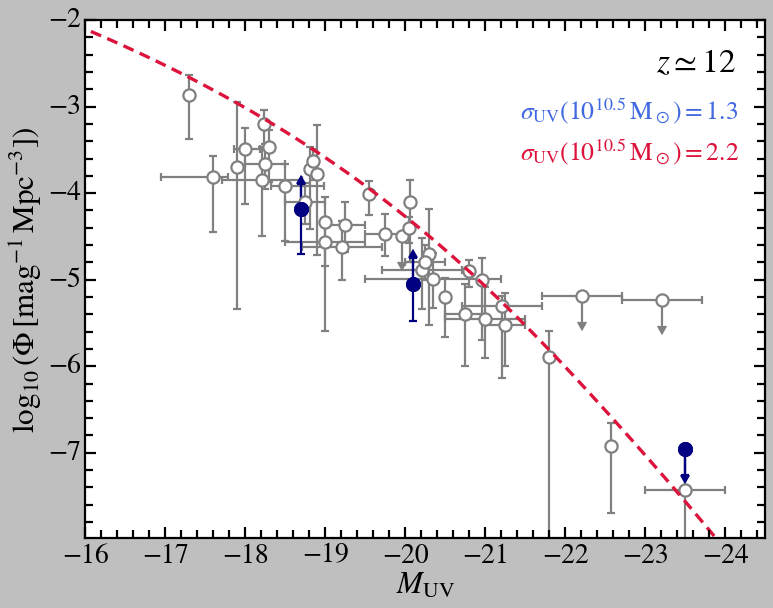

In [74]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

##
def sigma_uv_vs_mhalo_alt4(log_mhalo, yfloor, delta, ymax=2.0, xbreak = 9.0):
    y = 1.1 - 0.34 * (log_mhalo - 10) + delta

    if yfloor + delta > ymax:
        y = np.ones_like(log_mhalo) * (yfloor + delta)
        y[log_mhalo > xbreak] = 0
        return y
    yfloor = max(yfloor, 0)
    y[y<yfloor] = yfloor
    y[y>ymax] = ymax
    y[log_mhalo > xbreak] = 0
    return y
##

redshift = 12
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters=parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters=parameters_ede)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default

i = 0
if True:
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=False, 
                                    variable_sigma_uv=lambda x: sigma_uv_vs_mhalo_alt5(x, 0.2, 0.0)) 
                                    #variable_sigma_uv= lambda x: sigma_uv_vs_mhalo_alt4(x, 0.2, 2.0, xbreak=10.0)) 
    plt.plot(muv_arr, np.log10(phi_uv_arr), color="crimson", lw=3, linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

if False:
    muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=False, 
                                    #variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt3(x, 9.5, 2.2, 1.0)) 
                                    variable_sigma_uv= lambda x: sigma_uv_vs_mhalo_alt4(x, 0.2, 0.4, xbreak=10.0)) 
    plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), color='royalblue', lw=3, 
         linestyle="--" if i==0 else "-", dashes=(10,6) if i==0 else (1,0))

kwargs = {"ms": 11,  "color": "gray", "mec": "gray", "mfc": "white", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

plt.text(0.64, 0.81, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 0.4)[0]:.1f}", 
         color='royalblue', fontsize=23, transform = plt.gca().transAxes)
plt.text(0.64, 0.73, r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)=$"+f"{vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 2.0)[0]:.1f}", 
         color='crimson', fontsize=23, transform = plt.gca().transAxes)

#leg = plt.legend(fontsize=25, loc=3, frameon=True, framealpha=1, handlelength=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
#plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")
plt.show()

### benchmark at lower z

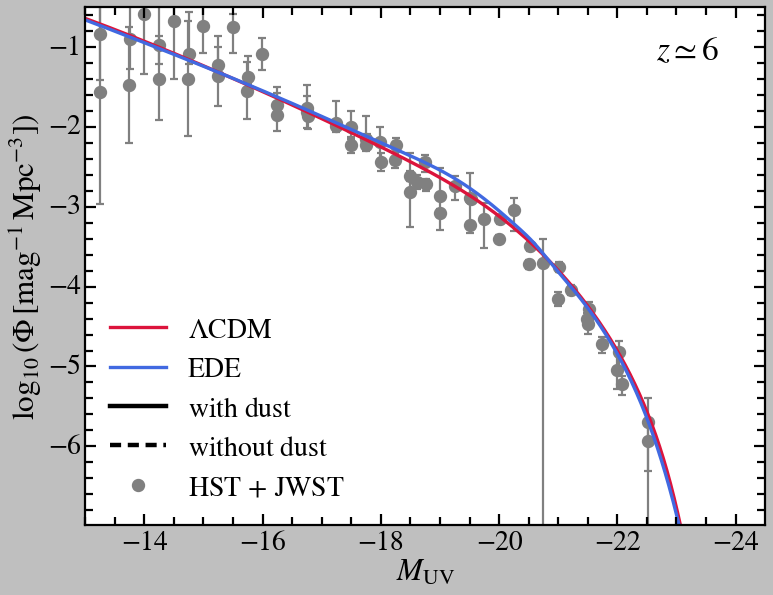

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

########
redshift = 6
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
epsilon = "this_work" #"H22_z7" 

sigma_floor = 0.2
#muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
#                                    parameters=parameters_std, cosmo=cosmo_std,
#                                    epsilon=epsilon, redshift=redshift, include_dust=False, 
#									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt(x, sigma_floor))   
#plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="--", dashes=(10,6))

muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt(x, sigma_floor))   
plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="-", label = r'$\Lambda{\rm CDM}$')

sigma_floor = 0.2
#muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
#                                    parameters=parameters_ede, cosmo=cosmo_ede,
#                                    epsilon=epsilon, redshift=redshift, include_dust=False,
#									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, sigma_floor, -0.4))  
#plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
#         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
#		 color='royalblue', lw=4, linestyle="--", dashes=(10,6))

muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True,
									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, sigma_floor, -0.4))  
plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
		 color='royalblue', lw=3, linestyle="-", label="EDE")
         
plt.plot([],[],'-', c='black', lw=4, label=r"$\rm with\,\,dust$")
plt.plot([],[],'--', dashes=(10,6), c='black', lw=4, label=r"$\rm without\,\,dust$")

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm HST\,+\,JWST$", **kwargs)

obs.plot_preJWST_constraints(redshift, ax=ax, **kwargs)

leg = plt.legend(fontsize=25, loc=3, frameon=False, numpoints=1)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-13, -24.5); plt.ylim(-6.99, -0.5); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


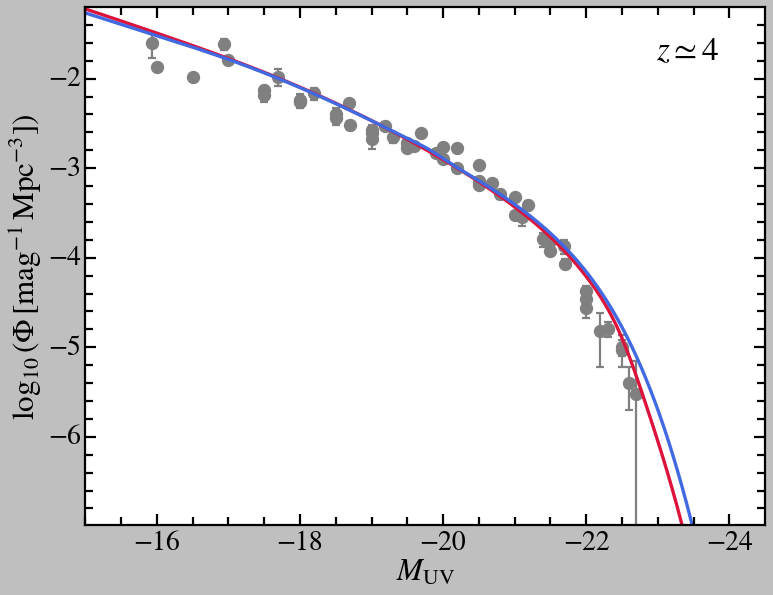

In [12]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

########
redshift = 4
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
epsilon = "this_work" #"H22_z7" 

sigma_floor = 0.2
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, sigma_floor, 0.0))   
plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="-")
#np.savetxt(f"./tabulated_output/UVLF_z{redshift:.1f}_sigma-mhalo.csv", np.c_[muv_arr, np.log10(phi_uv_arr)],
#               delimiter=", ", fmt="%.3f", header="Muv [AB mag], log10(Phi[#/cMpc^3/mag])")

sigma_floor = 0.2
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True,
									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, sigma_floor, -0.4))  
plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
		 color='royalblue', lw=3, linestyle="-")

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm HST$", **kwargs)

obs.plot_preJWST_constraints(redshift, ax=ax, **kwargs)

#leg = plt.legend(fontsize=25, loc=3, frameon=False, numpoints=1)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-15, -24.5)
if redshift >= 7:
    plt.ylim(-7.69, -1.2) 
else:
    plt.ylim(-6.99, -1.2)
plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


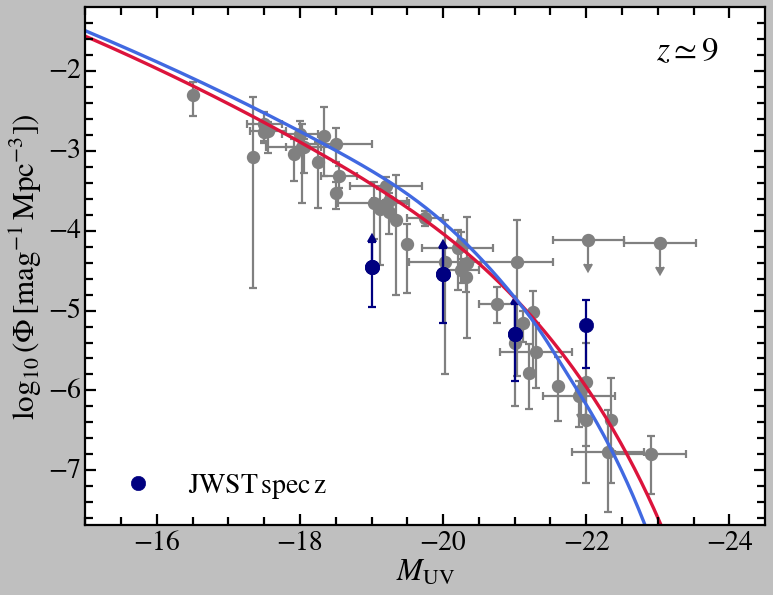

In [13]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

########
redshift = 9
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
epsilon = "this_work" #"H22_z7" 

sigma_floor = 0.2
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None, 
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt(x, sigma_floor))   
plt.plot(muv_arr, np.log10(phi_uv_arr), color='crimson', lw=3, linestyle="-")
np.savetxt(f"./tabulated_output/UVLF_z{redshift:.1f}_sigma-mhalo.csv", np.c_[muv_arr, np.log10(phi_uv_arr)],
               delimiter=", ", fmt="%.3f", header="Muv [AB mag], log10(Phi[#/cMpc^3/mag])")

sigma_floor = 0.2
muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None, 
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True,
									variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, sigma_floor, -0.4))  
plt.plot(muv_arr - hmf_cosmo.mag_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
         np.log10(phi_uv_arr) - hmf_cosmo.phi_correct_cosmo(redshift,cosmo_std,cosmo_ede), 
		 color='royalblue', lw=3, linestyle="-")

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
obs.plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)
#plt.errorbar([],[], label=r"$\rm HST$", **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -7}
obs.plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm JWST\,spec\,z$", **kwargs)

leg = plt.legend(fontsize=25, loc=3, frameon=False, numpoints=1)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\simeq{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-15, -24.5); plt.ylim(-7.69, -1.2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

### halo number density

In [73]:
from utilities import lf_processing

In [74]:
def compute_cumulative_halo_count(logmhalo, phihalo, target_mass=None):
    dlogmh = np.abs(logmhalo[1] - logmhalo[0]) # a constant
    if target_mass is None:
        cum_phi_arr = np.zeros(len(phihalo))
        for i in range(len(phihalo)):
            cum_phi_arr[i] = np.sum(phihalo[i:]) * dlogmh
        return cum_phi_arr # [#/Mpc^3]
    else:
        select = logmhalo >= target_mass
        return np.sum(phihalo[select]) * dlogmh # [#/Mpc^3]

In [75]:
redshift_list = np.linspace(2, 16, 20)
ystd = np.zeros((len(redshift_list),4))
yede = np.zeros((len(redshift_list),4))

for i, redshift in enumerate(redshift_list):
    mass_resolution = 0.01 
    mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_std, parameters =parameters_std)
    mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, 
                                                  cosmo=cosmo_ede, parameters =parameters_ede)
    
    ystd[i,0] = compute_cumulative_halo_count(mhalo_arr, phi_halo_arr, target_mass=9)
    ystd[i,1] = compute_cumulative_halo_count(mhalo_arr, phi_halo_arr, target_mass=10)
    ystd[i,2] = compute_cumulative_halo_count(mhalo_arr, phi_halo_arr, target_mass=11)
    ystd[i,3] = compute_cumulative_halo_count(mhalo_arr, phi_halo_arr, target_mass=12)

    yede[i,0] = compute_cumulative_halo_count(mhalo_arr_ede, phi_halo_arr_ede, target_mass=9)
    yede[i,1] = compute_cumulative_halo_count(mhalo_arr_ede, phi_halo_arr_ede, target_mass=10)
    yede[i,2] = compute_cumulative_halo_count(mhalo_arr_ede, phi_halo_arr_ede, target_mass=11)
    yede[i,3] = compute_cumulative_halo_count(mhalo_arr_ede, phi_halo_arr_ede, target_mass=12)

/opt/anaconda3/envs/env-python3.8/lib/python3.8/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))


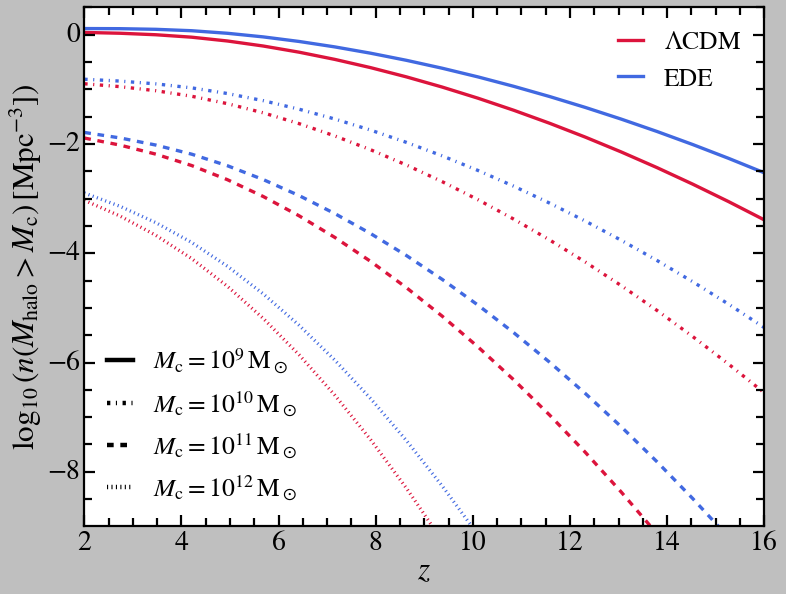

In [79]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

l1,  = plt.plot(redshift_list, np.log10(ystd[:,0]), color='crimson', lw=3, linestyle="-")
l2,  = plt.plot(redshift_list, np.log10(yede[:,0]), color='royalblue', lw=3, linestyle="-")
leg = plt.legend([l1, l2], [r"$\Lambda{\rm CDM}$", "EDE"], fontsize=23, loc=1, frameon=False, handlelength=1.0)

plt.plot(redshift_list, np.log10(ystd[:,1]), color='crimson', lw=3, linestyle="-.")
plt.plot(redshift_list, np.log10(yede[:,1]), color='royalblue', lw=3, linestyle="-.")

plt.plot(redshift_list, np.log10(ystd[:,2]), color='crimson', lw=3, linestyle="--")
plt.plot(redshift_list, np.log10(yede[:,2]), color='royalblue', lw=3, linestyle="--")

plt.plot(redshift_list, np.log10(ystd[:,3]), color='crimson', lw=3, linestyle=":")
plt.plot(redshift_list, np.log10(yede[:,3]), color='royalblue', lw=3, linestyle=":")

plt.plot([],[],'-', c='black', lw=4, label=r"$M_{\rm c} = 10^{9}\,{\rm M}_\odot$")
plt.plot([],[],'-.', c='black', lw=4, label=r"$M_{\rm c} = 10^{10}\,{\rm M}_\odot$")
plt.plot([],[],'--', c='black', lw=4, label=r"$M_{\rm c} = 10^{11}\,{\rm M}_\odot$")
plt.plot([],[],':', c='black', lw=4, label=r"$M_{\rm c} = 10^{12}\,{\rm M}_\odot$")

plt.legend(fontsize=23, loc=3, frameon=False, numpoints=1, handlelength=1.0)
ax.add_artist(leg)
plt.xlabel(r'$z$', fontsize=28)
plt.ylabel(r"$\log_{10}{(n(M_{\rm halo}>M_{\rm c})\,[{\rm Mpc}^{-3}])}$", fontsize=28)

plt.xlim(2, 16); plt.ylim(-8.99, 0.5); 
plt.gca().tick_params(labelsize=25, size=10)
#plt.show()
plt.savefig(f"figures/halo_count_vs_redshift.pdf")

## constraints in the parameter space

In [14]:
# benchmark  

# constraints that defines a model "work"
constraints = {
    "photo": {
        12: [(-20, -4.8)],
        14: [(-19, -4.4)],
        16: [(-19, -4.5)],
    },
    "spec": {
        12: [(-20.1,  np.log10(8.8e-06)), (-18.7,  np.log10(6.6e-05))]
    }
}

def search_grid_point( epsilon_corr, delta_sigma ):
    pass_photo_z16 = [True, True]
    pass_photo_z14 = [True, True]
    pass_photo_z12 = [True, True]
    pass_spec_z12  = [True, True]

    for redshift in [12, 14, 16]:
        mass_resolution = 0.01 
        mhalo_arr, phi_halo_arr = hmf_cosmo.calculate_hmf_kmaxfixed(z=redshift, Mmin=8, Mmax=16, dlog10m = mass_resolution, 
                                                                    cosmo=cosmo_std, parameters =parameters_std)
        mhalo_arr_ede, phi_halo_arr_ede = hmf_cosmo.calculate_hmf_ede(z=redshift, Mmin=8, Mmax=16, dlog10m = mass_resolution, 
                                                                    cosmo=cosmo_ede, parameters =parameters_ede)
        epsilon = f"vary_{epsilon_corr}" 

        muv_arr, phi_uv_arr = lf_mapping.compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv = None,
                                    parameters=parameters_std, cosmo=cosmo_std,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, 0.0 + delta_sigma))                  
        
        muv_arr_ede, phi_uv_arr_ede = lf_mapping.compute_uv_luminosity_function(mhalo_arr_ede, phi_halo_arr_ede, sigma_uv = None,
                                    parameters=parameters_ede, cosmo=cosmo_ede,
                                    epsilon=epsilon, redshift=redshift, include_dust=True, 
                                    variable_sigma_uv=lambda x: vab.sigma_uv_vs_mhalo_alt2(x, 0.2, -0.4 + delta_sigma))  

        if (redshift == 12):
            for (muv_lim,phi_lim) in constraints["spec"][redshift]:
                select = muv_arr < muv_lim
                pass_spec_z12[0] = np.log10(phi_uv_arr)[select][0] >= phi_lim
                select = muv_arr_ede < muv_lim
                pass_spec_z12[1] = np.log10(phi_uv_arr_ede)[select][0] >= phi_lim
        
        if (redshift == 12):
            for (muv_lim,phi_lim) in constraints["photo"][redshift]:
                select = muv_arr < muv_lim
                pass_photo_z12[0] = np.log10(phi_uv_arr)[select][0] >= phi_lim
                select = muv_arr_ede < muv_lim
                pass_photo_z12[1] = np.log10(phi_uv_arr_ede)[select][0] >= phi_lim

        if (redshift == 14):
            for (muv_lim,phi_lim) in constraints["photo"][redshift]:
                select = muv_arr < muv_lim
                pass_photo_z14[0] = np.log10(phi_uv_arr)[select][0] >= phi_lim
                select = muv_arr_ede < muv_lim
                pass_photo_z14[1] = np.log10(phi_uv_arr_ede)[select][0] >= phi_lim

        if (redshift == 16):
            for (muv_lim,phi_lim) in constraints["photo"][redshift]:
                select = muv_arr < muv_lim
                pass_photo_z16[0] = np.log10(phi_uv_arr)[select][0] >= phi_lim
                select = muv_arr_ede < muv_lim
                pass_photo_z16[1] = np.log10(phi_uv_arr_ede)[select][0] >= phi_lim
        
    return pass_spec_z12, pass_photo_z12, pass_photo_z14, pass_photo_z16

In [45]:
epsilon_corr_grid = np.logspace(np.log10(0.3), np.log10(6), 30)
sigma_uv_grid     = np.linspace(-0.8, 1.0, 30)

active = False
if active:
    pass_spec_z12_grid  = - np.ones((len(epsilon_corr_grid),2))
    pass_photo_z12_grid = - np.ones((len(epsilon_corr_grid),2))
    pass_photo_z14_grid = - np.ones((len(epsilon_corr_grid),2))
    pass_photo_z16_grid = - np.ones((len(epsilon_corr_grid),2))
    
    jstart = 0
    for i in range(len(epsilon_corr_grid)):
        jstart_changed = False
        for j in range(jstart, len(sigma_uv_grid)):
            print(i,j)
            pass_spec_z12, pass_photo_z12, pass_photo_z14, pass_photo_z16 =  search_grid_point( epsilon_corr_grid[i], sigma_uv_grid[j] )
            for k in range(2): # loop over cosmology
                if (pass_spec_z12[k]) and (pass_spec_z12_grid[i,k]==-1):
                    pass_spec_z12_grid[i,k]  = sigma_uv_grid[j]

                if (pass_photo_z12[k]) and (pass_photo_z12_grid[i,k]==-1): 
                    pass_photo_z12_grid[i,k] = sigma_uv_grid[j]

                if (pass_photo_z14[k]) and (pass_photo_z14_grid[i,k]==-1): 
                    pass_photo_z14_grid[i,k] = sigma_uv_grid[j]

                if (pass_photo_z16[k]) and (pass_photo_z16_grid[i,k]==-1):
                    pass_photo_z16_grid[i,k]  = sigma_uv_grid[j]
            
            if pass_photo_z12[0] and pass_photo_z12[1] and pass_spec_z12[0] and pass_spec_z12[1]:
                if pass_photo_z14[0] and pass_photo_z14[1] and pass_photo_z16[0] and pass_photo_z16[1]:
                    break
                

In [46]:
if active:
    np.save("pass_spec_z12_grid.npy", pass_spec_z12_grid)
    np.save("pass_photo_z12_grid.npy", pass_photo_z12_grid)
    np.save("pass_photo_z14_grid.npy", pass_photo_z14_grid)
    np.save("pass_photo_z16_grid.npy", pass_photo_z16_grid)
else:
    pass_spec_z12_grid  = np.load("pass_spec_z12_grid.npy")
    pass_photo_z12_grid = np.load("pass_photo_z12_grid.npy")
    pass_photo_z14_grid = np.load("pass_photo_z14_grid.npy")
    pass_photo_z16_grid = np.load("pass_photo_z16_grid.npy")

In [47]:
from scipy.signal import savgol_filter

def poly_fit(xtar, x, y, deg=3):
    sel = np.isfinite(y)
    p = np.polyfit(x[sel], y[sel], deg)
    return np.polyval(p, xtar)

0.02/sf.star_formation_efficiency_fiducial(10**(10.5))

0.8121110288246707

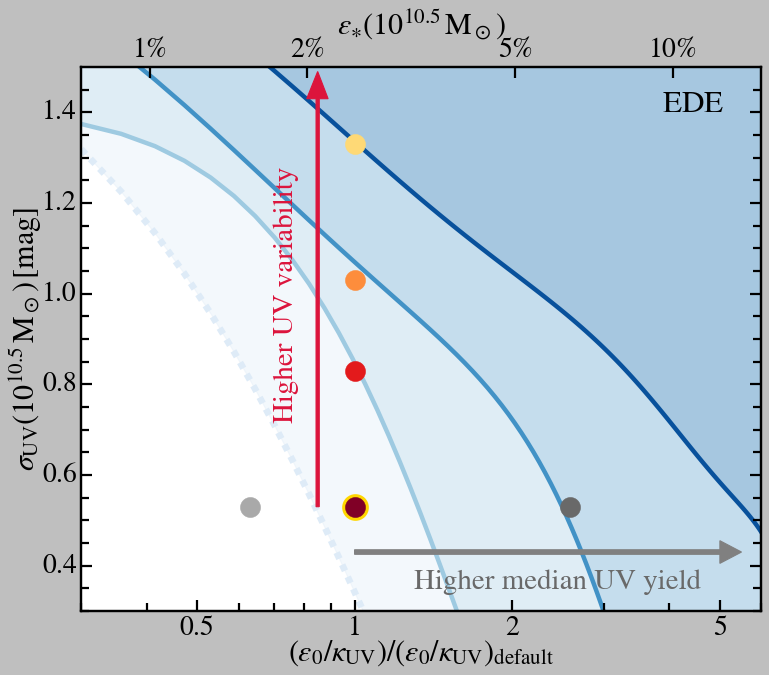

In [48]:
fig = plt.figure(figsize=(10,8.5))
ax = fig.add_axes([0.11, 0.10, 0.85, 0.80])

# plot as step
colorlist_pspace = ["#9ecae1", "#4292c6", "#084594", "gray"] 

offset = vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, -0.4)[0]
xdummy = np.linspace(epsilon_corr_grid[0], epsilon_corr_grid[-1], 100)

yphoto_z16 = pass_photo_z16_grid[:,1].copy()
yphoto_z16[yphoto_z16==-1] = np.inf # dummy number here
#plt.step(epsilon_corr_grid, yphoto_z16 + offset, lw=4, linestyle='-', where='mid', color=colorlist_default3[3])
yphoto_z16 = poly_fit(xdummy, epsilon_corr_grid, yphoto_z16, deg=5)
plt.plot(xdummy, yphoto_z16 + offset, lw=4, linestyle='-', color=colorlist_default3[3])

yphoto_z14 = pass_photo_z14_grid[:,1].copy()
yphoto_z14[yphoto_z14==-1] = np.inf # dummy number here
yphoto_z14 = poly_fit(xdummy, epsilon_corr_grid, yphoto_z14, deg=5)
plt.plot(xdummy, yphoto_z14 + offset, lw=4, linestyle='-', color=colorlist_default3[2])

yphoto_z12 = pass_photo_z12_grid[:,1].copy()
yphoto_z12[yphoto_z12==-1] = np.inf # dummy number here
yphoto_z12 = poly_fit(xdummy, epsilon_corr_grid, yphoto_z12, deg=5)
plt.plot(xdummy, yphoto_z12 + offset, lw=4, linestyle='-', color=colorlist_default3[1])

yspec = pass_spec_z12_grid[:,1]
yspec = poly_fit(xdummy, epsilon_corr_grid, yspec, deg=5)
plt.plot(xdummy, yspec + offset, lw=6, linestyle='--', color=colorlist_default3[0])


y2 = np.ones(len(xdummy)) * 3
plt.fill_between(xdummy, y1=yphoto_z16 + offset, y2=y2, color=colorlist_default3[3], alpha=0.4)
plt.fill_between(xdummy, y1=yphoto_z14 + offset, y2=y2, color=colorlist_default3[2], alpha=0.3)
plt.fill_between(xdummy, y1=yphoto_z12 + offset, y2=y2, color=colorlist_default3[1], alpha=0.3)
plt.fill_between(xdummy, y1=yspec + offset, y2=y2, color=colorlist_default3[0], alpha=0.35)

plt.plot(1, 0.0 + offset, marker="o", color=colorlist_default[3], mec="gold", mew=5, ms=19)
plt.plot(1, 0.0 + offset, marker="o", color=colorlist_default[3], mec=colorlist_default[3], ms=18)
plt.plot(1, 0.3 + offset, marker="o", color=colorlist_default[2], mec=colorlist_default[2], ms=18)
plt.plot(1, 0.5 + offset, marker="o", color=colorlist_default[1], mec=colorlist_default[1], ms=18)
plt.plot(1, 0.8 + offset, marker="o", color=colorlist_default[0], mec=colorlist_default[0], ms=18)

plt.plot(0.63, 0.0 + offset, marker="o"      , color="darkgray", mec="darkgray", ms=18)
plt.plot(3.57/(1/1.15/0.63), 0.0 + offset, marker="o"      , color="dimgray", mec="dimgray", ms=18)

plt.arrow(0.85, offset  , 0, 0.9, width=0.012, head_width=0.08, head_length=0.06, fc='crimson', ec='crimson', zorder=10)
plt.arrow(1.0, -0.1 + offset, 4, 0  , width=0.01, head_width=0.05, head_length=0.5, fc='gray', ec='gray', zorder=10)

plt.text(1.3, -0.18+offset, "Higher median UV yield", fontsize=26, color="dimgray", zorder=10)
plt.text(0.7, 0.2+offset, "Higher UV variability", fontsize=26, color="crimson", rotation=90, zorder=10)

plt.text(0.9, 0.93, r"${\rm EDE}}$", fontsize=28, color="black", rotation=0, 
         transform=ax.transAxes, ha='center', va='center')

plt.xscale("log")
plt.xlabel(r"$(\epsilon_{0}/\kappa_{\rm UV}) / (\epsilon_{0}/\kappa_{\rm UV})_{\rm default}$", fontsize=27, labelpad=-3)
plt.ylabel(r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)\,[{\rm mag}]$", fontsize=27, labelpad=-2)
plt.xlim(np.min(epsilon_corr_grid), np.max(epsilon_corr_grid)); plt.ylim(0.3, 1.5)
# set the xticks manually
plt.xticks([0.5, 1, 2, 5], ["0.5","1", "2", "5"])
ax.tick_params(labelsize=25, size=10)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale("log")
sfe_offset = sf.star_formation_efficiency_fiducial(10**(10.5))
ax2.set_xticks(np.array([0.01, 0.02, 0.05, 0.1]) / sfe_offset)
ax2.set_xticklabels([r"$1\%$", r"$2\%$", r"$5\%$", r"$10\%$"])
ax2.set_xlabel(r"$\epsilon_{\ast}(10^{10.5}\,{\rm M}_\odot)$", fontsize=27, labelpad=3)
ax2.tick_params(labelsize=25, size=10)
ax2.tick_params(which='minor', axis='x', top=False)

plt.savefig(f"figures/parameter_space_ede.pdf")

-0.8
[       inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf 0.56551724 0.44137931 0.37931034 0.31724138 0.25517241
 0.25517241 0.19310345 0.13103448 0.13103448 0.06896552 0.00689655]


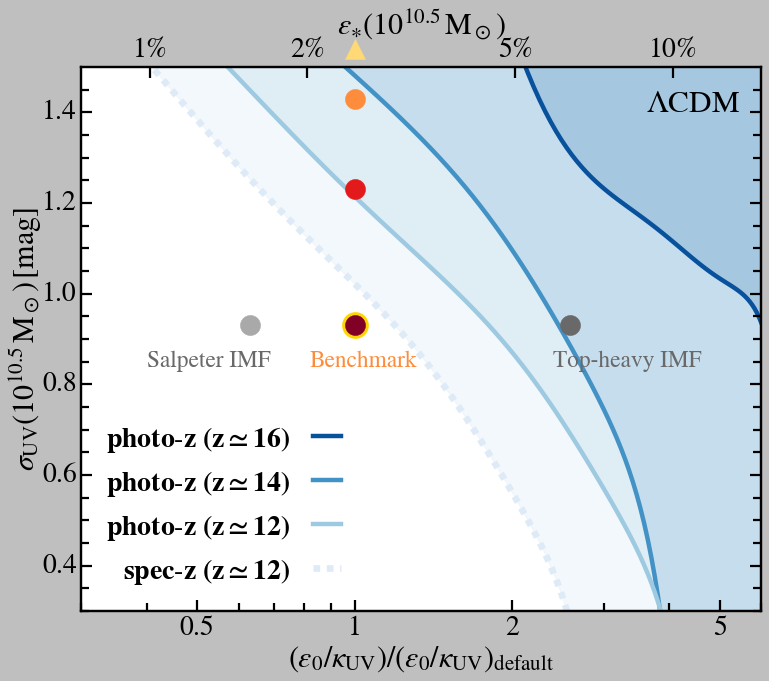

In [57]:
fig = plt.figure(figsize=(10,8.5))
ax = fig.add_axes([0.11, 0.10, 0.85, 0.80])

# plot as step
color_pspace = ["#9ecae1", "#4292c6", "#084594"] 

offset = vab.sigma_uv_vs_mhalo_alt2(np.array([10.5]), 0.2, 0.0)[0]
minimum = np.min(sigma_uv_grid) 
print(minimum)

yphoto_z16 = pass_photo_z16_grid[:,0].copy()
yphoto_z16[yphoto_z16==-1] = np.inf # dummy number here
yphoto_z16[yphoto_z16<=minimum] = np.inf
print(yphoto_z16)
#plt.step(epsilon_corr_grid, yphoto_z16 + offset, lw=4, linestyle='-', color=colorlist_default3[3])
yphoto_z16 = poly_fit(xdummy, epsilon_corr_grid, yphoto_z16, deg=5)
plt.plot(xdummy, yphoto_z16 + offset, lw=4, linestyle='-', color=colorlist_default3[3], label=r"$\rm \bf photo$-$\rm \bf z\,\,(z\simeq 16)$")

yphoto_z14 = pass_photo_z14_grid[:,1].copy()
yphoto_z14[yphoto_z14==-1] = np.inf # dummy number here
yphoto_z14[yphoto_z14<=minimum] = np.inf
yphoto_z14 = poly_fit(xdummy,epsilon_corr_grid, yphoto_z14, deg=5)
plt.plot(xdummy, yphoto_z14 + offset, lw=4, linestyle='-', color=colorlist_default3[2], label=r"$\rm \bf photo$-$\rm \bf z\,\,(z\simeq 14)$")

yphoto_z12 = pass_photo_z12_grid[:,0].copy()
yphoto_z12[yphoto_z12==-1] = np.inf # dummy number here
yphoto_z12[yphoto_z12<=minimum] = np.inf
yphoto_z12 = poly_fit(xdummy,epsilon_corr_grid, yphoto_z12, deg=5)
plt.plot(xdummy, yphoto_z12 + offset, lw=4, linestyle='-', color=colorlist_default3[1], label=r"$\rm \bf photo$-$\rm \bf z\,\,(z\simeq 12)$")

yspec = pass_spec_z12_grid[:,0]
yspec[yspec<=minimum] = np.inf
yspec = poly_fit(xdummy,epsilon_corr_grid, yspec, deg=5)
plt.plot(xdummy, yspec + offset, lw=6, linestyle='--', color=colorlist_default3[0], label=r"$\rm \bf spec$-$\rm \bf z\,\,(z\simeq 12)$")


y2 = np.ones(len(xdummy)) * 3
plt.fill_between(xdummy, y1=yphoto_z16 + offset,   y2=y2, color=colorlist_default3[3], alpha=0.4)
plt.fill_between(xdummy, y1=yphoto_z14 + offset,   y2=y2, color=colorlist_default3[2], alpha=0.3)
plt.fill_between(xdummy, y1=yphoto_z12 + offset,   y2=y2, color=colorlist_default3[1], alpha=0.3)
plt.fill_between(xdummy, y1=yspec + offset, y2=y2, color=colorlist_default3[0], alpha=0.35)


plt.plot(1, 0.0 + offset, marker="o", color=colorlist_default[3], mec="gold", mew=5, ms=19)
plt.plot(1, 0.0 + offset, marker="o", color=colorlist_default[3], mec=colorlist_default[3], ms=18)
plt.plot(1, 0.3 + offset, marker="o", color=colorlist_default[2], mec=colorlist_default[2], ms=18)
plt.plot(1, 0.5 + offset, marker="o", color=colorlist_default[1], mec=colorlist_default[1], ms=18)

plt.plot(1, 0.61 + offset, marker="^", color=colorlist_default[0], mec=colorlist_default[0], ms=18, clip_on=False, zorder=20)

plt.plot(0.63, 0.0 + offset, marker="o"      , color="darkgray", mec="darkgray", ms=18)
plt.plot(3.57/(1/1.15/0.63), 0.0 + offset, marker="o"      , color="dimgray", mec="dimgray", ms=18)

plt.text(0.82, -0.09 + offset, "Benchmark", fontsize=21, color=colorlist_default[1])
plt.text(0.4, -0.09 + offset, "Salpeter IMF" , fontsize=21, color="dimgray", zorder=10)
plt.text(2.4, -0.09 + offset, "Top-heavy IMF", fontsize=21, color="dimgray", zorder=10)

#ax.plot(0.87, 0.75, '.', marker='_', markersize=12, mew=3, color="chocolate")
#ax.errorbar(0.87, 2.2, yerr=([0],[0.1]), marker='_', markersize=15, mew=3, lw=3, capsize=5, lolims=True, color="chocolate")

plt.text(0.9, 0.93, r"$\Lambda{\rm CDM}$", fontsize=28, color="black", rotation=0, 
         transform=ax.transAxes, ha='center', va='center')

ax.legend(loc=3, frameon=False, fontsize=25, numpoints=1, ncol=1, handlelength=1, markerfirst=False)

plt.xscale("log")
plt.xlabel(r"$(\epsilon_{0}/\kappa_{\rm UV}) / (\epsilon_{0}/\kappa_{\rm UV})_{\rm default}$", fontsize=27)
plt.ylabel(r"$\sigma_{\rm UV}(10^{10.5}\,{\rm M}_\odot)\,[{\rm mag}]$", fontsize=27, labelpad=-2)
plt.xlim(np.min(epsilon_corr_grid), np.max(epsilon_corr_grid)); plt.ylim(0.3, 1.5)
# set the xticks manually
plt.xticks([0.5, 1, 2, 5], ["0.5","1", "2", "5"])
ax.tick_params(labelsize=25, size=10)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale("log")
sfe_offset = sf.star_formation_efficiency_fiducial(10**(10.5))
ax2.set_xticks(np.array([0.01, 0.02, 0.05, 0.1]) / sfe_offset)
ax2.set_xticklabels([r"$1\%$", r"$2\%$", r"$5\%$", r"$10\%$"])
ax2.set_xlabel(r"$\epsilon_{\ast}(10^{10.5}\,{\rm M}_\odot)$", fontsize=27, labelpad=3)
ax2.tick_params(labelsize=25, size=10)
ax2.tick_params(which='minor', axis='x', top=False)

plt.savefig(f"figures/parameter_space.pdf")